In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
from time import time
import matplotlib.pyplot as plt
import math
import joypy
%matplotlib inline

Use a colorblind color palette for plotting.

In [2]:
plt.style.use('tableau-colorblind10')

Set the random seed here - reproducibility.

In [3]:
np.random.seed(2225)

Read in the data set.

In [4]:
df = pd.read_csv("../data/2131-2208_cleaned.csv") # Fall 2013 - Summer 2021
dfL = pd.read_csv("../data/2021-2208_cleaned_anon.csv") # Fall 2002 - Summer 2021, longer data set

/var/folders/8y/r62j7z6j4md8f6m5__xps3hn3v0r_4/T/ipykernel_76461/2305442081.py:2: DtypeWarning: Columns (7,8,9,10,30) have mixed types. Specify dtype option on import or set low_memory=False.
  dfL = pd.read_csv("../data/2021-2208_cleaned_anon.csv") # Fall 2002 - Summer 2021, longer data set


Read in the LA course informtion from Emily

In [5]:
df.columns

Index(['ID', 'Cohort Term', 'degree_seeking', 'acad_level_code',
       'NTID support', 'gender', 'AALANA', 'subject', 'catalog_nbr',
       'class_section', 'Course Title', 'section Type', 'Course hours',
       'grade type', 'Grade', 'dlmode', 'Acad Plan', 'College',
       'term Hours Att', 'term Hours Earn', 'term gpa', 'Cum GPA', 'sat_math',
       'sat_verb', 'act_math', 'act_write', 'Math Placement',
       'Degree Received', 'Degree Major', 'Degree Term', 'First Generation',
       'Term', 'Entry Term'],
      dtype='object')

In [6]:
sms_majors = ["APPMTH-BS", "CMTH-BS", "APPSTAT-BS"]
IDs_sms = df.loc[(df["Acad Plan"].isin(sms_majors)), "ID"].unique()

In [7]:
len(df.loc[(df.ID.isin(IDs_sms)) & (df.AALANA=="AALANA") & 
           (df["Degree Term"]>=2131) & (df["Degree Term"]<=2208),"ID"].unique())

32

In [8]:
len(df.loc[(df["Degree Major"].isin(sms_majors)) & (df.AALANA=="AALANA") & 
           (df["Degree Term"]>=2191) & (df["Degree Term"]<=2198),"ID"].unique())

4

In [9]:
LAdf = pd.read_csv("../data/LA_Courses_2205_23Mar2022.csv")
LAdf.rename(columns={"term":"Term"}, inplace=True)

The following changes Pandas options when displaying the DataFrame so that it doesn't give a "..." when there are too many columns.

In [10]:
pd.set_option("display.max_columns", 40, "display.max_rows", 200)

Note: these forms of the `compute_matrix` function assume that we are working with the LA data"

These versions account for partial data cohorts (e.g., the current Fall 2019 cohort, since they have not had 6 full years yet in the DataFrame)
  * uses a series of `if` statements to determine whether to proceed with calculating subsequent rows (year-to-year transitions) within the numbers matrix. Note that years where there is no data are left as 0s, so normalizing will give infinities/nans. Need to account for that on the user side by only adding these partial data fellas to matrices from cohort terms where we have enough data to estimate those entries
  
`compute_matrix_orig` (lower) is the original code from Mason/Tiana.
* takes in a DataFrame and `cohort_term`,
* grabs all students from that `cohort_term` who took classes during that term (misses transfer students)
* compute the "persisters" from Year N to N+1 as the subset of students from Year N who take classes in Year N+1 **OR** who have a `degree_term` that is after Year N.
  * those who have a `degree_term` in Year N go into the N-->depart (degree) transition numbers
  * those who no longer take classes **and** do not eventually obtain a degree go into the N-->depart (no degree) transition numbers
* only would account for students who have LAs during their first year (`cohort_term` or the following spring)
  * this original version is not adapted for the LA analysis in any specific way

`compute_matrix_las` is modified by Tony to adapt for the LA analysis
* accounts for students who have LAs in years besides their first year 
  * does this by (eg) checking who had LAs during their second year (relative to `cohort_term`), but were not already in the DataFrame from Year 1 (by virtue of having had LAs during Year 1). then does this for Years 2-6 too.

In [11]:
def compute_matrix_las(df, cohort_term, las=False, get_grad_ids=False): 
    '''
    This version is adding in students who have LAs in years 2-6 to 
    the students who have persisted from previous years (if las=True)
    '''

    # Set up initial matrix for numbers of students making each transition (from row i to column j)
    mat = np.zeros((8,8))
    grad_ids = set() # IDs of everyone who graduates

    # Check that there's data to at least calculate Y1-->Y2 transitions
    if len(df.loc[(df["Term"]>=cohort_term+10) & (df["Term"]<cohort_term+20)])==0:
        print("WARNING: Insufficient data to calculate any transitions. Ending.")
        return

    #===========================================================================
    # YEAR 1 CALCULATION 
    #===========================================================================
  
    # Find all the IDs of students in the specified cohort that were at RIT for the first year
    if las:
        IDY1 = df.loc[(df["Cohort Term"] == cohort_term) & 
                      ((df["Term"] >= cohort_term) & (df["Term"] < cohort_term+10)) &
                      (df["LAexperience"]==1), "ID"].unique()
    else:
        IDY1 = df.loc[(df["Cohort Term"] == cohort_term) & 
                      ((df["Term"] >= cohort_term) & (df["Term"] < cohort_term+10)), "ID"].unique()
    # Save a new dataframe, dfY1, that just has those IDs, for all years they show up total
    dfY1 = df.loc[df["ID"].isin(IDY1)]

    #===========================================================================
    # YEAR 1 -> 2 CALCULATION AND TRANSITIONS
    #===========================================================================
    
    # Among those who started Y1, who is Y1->Grad?
    grads = dfY1.loc[(dfY1["Degree Term"]>=cohort_term) & (dfY1["Degree Term"]<cohort_term+10),"ID"].unique()
    mat[0,7] = len(grads)
    grad_ids = set.union(grad_ids, set(grads))
    
    # continue and dropout IDs
    CandD = set.difference(set(IDY1),set(grads))
    
    # Among Y1->(not Grad), who appears again in a future year? (either classes or a degree)
    IDY2 = dfY1.loc[(dfY1.ID.isin(CandD)) & 
                    ((dfY1["Term"]>=cohort_term+10) | (dfY1["Degree Term"]>=cohort_term+10)),"ID"].unique()
    dfY2 = dfY1.loc[dfY1.ID.isin(IDY2)]
    mat[0,1] = len(dfY2.ID.unique()) 
    
    departures = set.difference(CandD, set(IDY2)) 
    mat[0,6] = len(departures)

    #===========================================================================
    # YEAR 2 -> 3 CALCULATION AND TRANSITIONS
    #===========================================================================

    if len(df.loc[(df["Term"]>=cohort_term+20) & (df["Term"]<cohort_term+30)])>0:
        # only continue if we have data. otherwise, leave as 0s
        
        # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
        # Now the starters for Y2 should include persisters from Y1 (dfY2) AND the
        # students from the desired cohort_term who have LAs in their second year, AND
        # who were not in the Y1 dataframe.
        # Concatenate the persisters from Y1 with those from the desired cohort_term who have LAs in their second year
        # Note that we can remove the `LAexperience` constraint and this will effectively be accounting for transfer students
        if las:
            IDY2LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                             ((df["Term"]>=cohort_term+10) & (df["Term"]<cohort_term+20)) &
                             (~df["ID"].isin(IDY1)) & (df["LAexperience"]==1),"ID"].unique()
            IDadd = set.difference(set(IDY2LAs),set(IDY1))
            dfY2LAs = df.loc[(df["Term"]>=cohort_term+10) &
                             (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]
            # Concatenate the dfY2 DataFrame with the above
            dfY2c = pd.concat([dfY2,dfY2LAs],ignore_index=True)
            # Need to reset the set of IDs
            IDY2 = dfY2c["ID"].unique()
        else:
            dfY2c = dfY2.copy()
        # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****
        
        # Among those who started Y2, who is Y2->Grad?
        grads = dfY2c.loc[(dfY2c["Degree Term"]>=cohort_term+10) & (dfY2c["Degree Term"]<cohort_term+20),"ID"].unique()
        mat[1,7] = len(grads)
        grad_ids = set.union(grad_ids, set(grads))

        # continue and dropout IDs
        CandD = set.difference(set(IDY2),set(grads))

        # Among Y2->(not Grad), who appears again in a future year? (either classes or a degree)
        IDY3 = dfY2c.loc[(dfY2c.ID.isin(CandD)) & 
                         ((dfY2c["Term"]>=cohort_term+20) | (dfY2c["Degree Term"]>=cohort_term+20)),"ID"].unique()
        dfY3 = dfY2c.loc[dfY2c.ID.isin(IDY3)]
        mat[1,2] = len(dfY3.ID.unique()) 

        departures = set.difference(CandD, set(IDY3))
        mat[1,6] = len(departures)

        #===========================================================================
        # YEAR 3 -> 4 CALCULATION AND TRANSITIONS
        #===========================================================================

        if len(df.loc[(df["Term"]>=cohort_term+30) & (df["Term"]<cohort_term+40)])>0:
            # only continue if we have data. otherwise, leave as 0s

            # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
            # Now the starters for Y3 should include persisters from Y2 (dfY3) AND the
            # students from the desired cohort_term who have LAs in their third year, AND
            # who were not in the Y2 dataframe already.
            # Concatenate the persisters from Y2 with those from the desired cohort_term who have LAs in their third year
            if las:
                IDY3LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                 ((df["Term"]>=cohort_term+20) & (df["Term"]<cohort_term+30)) &
                                 (~df["ID"].isin(IDY2)) & (df["LAexperience"]==1),"ID"].unique()
                IDadd = set.difference(set(IDY3LAs),set(IDY2))
                dfY3LAs = df.loc[(df["Term"]>=cohort_term+20) &
                                 (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]
                # Concatenate the dfY3 DataFrame with the above
                dfY3c = pd.concat([dfY3,dfY3LAs],ignore_index=True)
                # Need to reset the set of IDs
                IDY3 = dfY3c["ID"].unique()
            else:
                dfY3c = dfY3.copy()
            # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

            # Among those who started Y3, who is Y3->Grad?
            grads = dfY3c.loc[(dfY3c["Degree Term"]>=cohort_term+20) & (dfY3c["Degree Term"]<cohort_term+30),"ID"].unique()
            mat[2,7] = len(grads)
            grad_ids = set.union(grad_ids, set(grads))

            # continue and dropout IDs
            CandD = set.difference(set(IDY3),set(grads))

            # Among Y3->(not Grad), who appears again in a future year? (either classes or a degree)
            IDY4 = dfY3c.loc[(dfY3c.ID.isin(CandD)) & 
                             ((dfY3c["Term"]>=cohort_term+30) | (dfY3c["Degree Term"]>=cohort_term+30)),"ID"].unique()
            dfY4 = dfY3c.loc[dfY3c.ID.isin(IDY4)]
            mat[2,3] = len(dfY4.ID.unique()) 

            departures = set.difference(CandD, set(IDY4))
            mat[2,6] = len(departures)

            #===========================================================================
            # YEAR 4 -> 5 CALCULATION AND TRANSITIONS
            #===========================================================================

            if len(df.loc[(df["Term"]>=cohort_term+40) & (df["Term"]<cohort_term+50)])>0:
                # only continue if we have data. otherwise, leave as 0s

                # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                # Now the starters for Y4 should include persisters from Y3 (dfY4) AND the
                # students from the desired cohort_term who have LAs in their fourth year, AND
                # who were not in the Y3 dataframe already.
                # Concatenate the persisters from Y3 with those from the desired cohort_term who have LAs in their fourth year
                if las:
                    IDY4LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                     ((df["Term"]>=cohort_term+30) & (df["Term"]<cohort_term+40)) &
                                     (~df["ID"].isin(IDY3)) & (df["LAexperience"]==1),"ID"].unique()
                    IDadd = set.difference(set(IDY4LAs),set(IDY3))
                    dfY4LAs = df.loc[(df["Term"]>=cohort_term+30) &
                                     (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]
                    # Concatenate the dfY4 DataFrame with the above
                    dfY4c = pd.concat([dfY4,dfY4LAs],ignore_index=True)
                    # Need to reset the set of IDs
                    IDY4 = dfY4c["ID"].unique()
                else:
                    dfY4c = dfY4.copy()
                # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                # Among those who started Y4, who is Y4->Grad?
                grads = dfY4c.loc[(dfY4c["Degree Term"]>=cohort_term+30) & (dfY4c["Degree Term"]<cohort_term+40),"ID"].unique()
                mat[3,7] = len(grads)
                grad_ids = set.union(grad_ids, set(grads))

                # continue and dropout IDs
                CandD = set.difference(set(IDY4),set(grads))

                # Among Y4->(not Grad), who appears again in a future year? (either classes or a degree)
                IDY5 = dfY4c.loc[(dfY4c.ID.isin(CandD)) & 
                                 ((dfY4c["Term"]>=cohort_term+40) | (dfY4c["Degree Term"]>=cohort_term+40)),"ID"].unique()
                dfY5 = dfY4c.loc[dfY4c.ID.isin(IDY5)]
                mat[3,4] = len(dfY5.ID.unique()) 

                departures = set.difference(CandD, set(IDY5))
                mat[3,6] = len(departures)

                #===========================================================================
                # YEAR 5 -> 6 CALCULATION AND TRANSITIONS
                #===========================================================================
                
                if len(df.loc[(df["Term"]>=cohort_term+50) & (df["Term"]<cohort_term+60)])>0:
                    # only continue if we have data. otherwise, leave as 0s

                    # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                    # Now the starters for Y5 should include persisters from Y4 (dfY5) AND the
                    # students from the desired cohort_term who have LAs in their fifth year, AND
                    # who were not in the Y4 dataframe already.
                    # Concatenate the persisters from Y4 with those from the desired cohort_term who have LAs in their fifth year
                    if las:
                        IDY5LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                         ((df["Term"]>=cohort_term+40) & (df["Term"]<cohort_term+50)) &
                                         (~df["ID"].isin(IDY4)) & (df["LAexperience"]==1),"ID"].unique()
                        IDadd = set.difference(set(IDY5LAs),set(IDY4))
                        dfY5LAs = df.loc[(df["Term"]>=cohort_term+40) &
                                         (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]
                        # Concatenate the dfY5 DataFrame with the above
                        dfY5c = pd.concat([dfY5,dfY5LAs],ignore_index=True)
                        # Need to reset the set of IDs
                        IDY5 = dfY5c["ID"].unique()
                    else:
                        dfY5c = dfY5.copy()
                    # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                    # Among those who started Y5, who is Y5->Grad?
                    grads = dfY5c.loc[(dfY5c["Degree Term"]>=cohort_term+40) & (dfY5c["Degree Term"]<cohort_term+50),"ID"].unique()
                    mat[4,7] = len(grads)
                    grad_ids = set.union(grad_ids, set(grads))

                    # continue and dropout IDs
                    CandD = set.difference(set(IDY5),set(grads))

                    # Among Y5->(not Grad), who appears again in a future year? (either classes or a degree)
                    IDY6 = dfY5c.loc[(dfY5c.ID.isin(CandD)) & 
                                     ((dfY5c["Term"]>=cohort_term+50) | (dfY5c["Degree Term"]>=cohort_term+50)),"ID"].unique()
                    dfY6 = dfY5c.loc[dfY5c.ID.isin(IDY6)]
                    mat[4,5] = len(dfY6.ID.unique()) 

                    departures = set.difference(CandD, set(IDY6))
                    mat[4,6] = len(departures)

                    #===========================================================================
                    # YEAR 6-> DEPARTURE AND OTHER CALCULATIONS
                    #===========================================================================
                    #if len(df.loc[(df["Term"]>=cohort_term+60) & (df["Term"]<cohort_term+70)])>0:
                    # only continue if we have data. otherwise, leave as 0s
                    # Y6 is a little different, because we only care about whether a degree is 
                    # obtained before (<) cohort_term+60. So, don't need to check farther out.

                    # ***** begin changes to account for LA-having (and changing dfYX --> dfYXc) *****
                    # Now the starters for Y6 should include persisters from Y5 (dfY6) AND the
                    # students from the desired cohort_term who have LAs in their sixth year, AND
                    # who were not in the Y5 dataframe already.
                    # Concatenate the persisters from Y5 with those from the desired cohort_term who have LAs in their sixth year
                    if las:
                        IDY6LAs = df.loc[(df["Cohort Term"]==cohort_term) & 
                                         ((df["Term"]>=cohort_term+50) & (df["Term"]<cohort_term+60)) &
                                         (~df["ID"].isin(IDY5)) & (df["LAexperience"]==1),"ID"].unique()
                        IDadd = set.difference(set(IDY6LAs),set(IDY5))
                        dfY6LAs = df.loc[(df["Term"]>=cohort_term+50) &
                                         (df["Cohort Term"]==cohort_term) & (df["ID"].isin(IDadd))]
                        # Concatenate the dfY5 DataFrame with the above
                        dfY6c = pd.concat([dfY6,dfY6LAs],ignore_index=True)
                        # Need to reset the set of IDs
                        IDY6 = dfY6c["ID"].unique()
                    else:
                        dfY6c = dfY6.copy()
                    # ***** end changes to account for LA-having (and changing dfYX --> dfYXc) *****

                    # Among those who started Y6, who is Y6->Grad?
                    grads = dfY6c.loc[(dfY6c["Degree Term"]>=cohort_term+50) & (dfY6c["Degree Term"]<cohort_term+60),"ID"].unique()
                    mat[5,7] = len(grads)
                    grad_ids = set.union(grad_ids, set(grads))

                    # After 6 years, everyone else goes into the Depart/Drop-out state
                    departures = set.difference(set(IDY6),set(grads))
                    mat[5,6] = len(departures)

    mat[6,6] = 1
    mat[7,7] = 1

    if get_grad_ids:
        return mat, grad_ids
    else:
        return mat

#===========================================================================
#===========================================================================

def normalize(mat):
    # Credit Mason Tedeschi 
    nmat = mat.copy()
    for row in range(mat.shape[0]):
        sum_row = np.sum(mat[row,:])
        if sum_row==0:
            nmat[row,:] = np.zeros(len(mat[row,:]))
        else:
            nmat[row,:] = mat[row,:]/sum_row
    return nmat # np.around([nmat], decimals=4)
    # I changed this return as well

In [12]:
# ====================================================================================================
# Find the students who took a list of classes
# ====================================================================================================


def get_IDs(lst, df):
    IDs = []
    for the_class in lst:
        class_IDs = list(df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]) & (df["class_section"]==the_class[2]) & (df["Term"]==the_class[3]), "ID"])
        if IDs == []:
            IDs.extend(class_IDs)
        else:
            IDs.extend(x for x in class_IDs if x not in IDs)
    return IDs

Construct a list of tuples of LA course information
* subject
* catalog number
* section
* term

In [13]:
LAclass_tups = list(LAdf.loc[:,['subject','catalog_nbr','class_section','Term']].drop_duplicates(subset=None, keep='first').to_records(index=False))


Student IDs who have been in a class with an LA but returning a dict.

*edit: **not** doing this:* Using `str()` for the catalog number because some of the numbers have letters in them.

**Warning: This takes a few minutes**

Will find a few classes that either were combined with other sections or are first-year writing seminars.

In [14]:
LA_students_dict = {}

start = time()
for the_class in LAclass_tups:
    class_IDs = list(df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]) & 
                            (df["class_section"]==the_class[2]) & (df["Term"]==the_class[3]), ['ID','Term']].to_records(index=False))
    if len(class_IDs)==0:
        print("WARNING: class not found:",the_class)
    for x in class_IDs:
        if x[0] not in LA_students_dict.keys():
            LA_students_dict[x[0]] = x[1] # add them to the dict if they aren't already there
        else:
            LA_students_dict[x[0]] = np.min([x[1],LA_students_dict[x[0]]]) # if they're there already, make sure the term is the earliest they had an LA
stop = time()
print("took ",(stop-start)/60,"minutes")

took  1.0954068660736085 minutes


## Breaking out the LA-having students, and the LA-assisted courses

Now each student who has had LAs is in `LA_students_dict` exactly once, and is associated with the term in which they **first** had an LA.

### Create a tag for courses that are LA-assisted so we can subset down to only those later

and

### Create a tag for students who have ever taken a course that has had LA-assisted sections

(includes students that have never had LAs)

Note that we just care about the `subject` and the `catalog_nbr` matching. Those are the first two elements in the tuples from `LAclass_tups`.

In [15]:
LA_classes = [(LAclass_tups[k][0], LAclass_tups[k][1]) for k in range(len(LAclass_tups))]
LA_classes = list(set(LA_classes))

df["LAassisted"] = 0         # tag for LA-assisted courses
df["LAclass_students"] = 0   # tag for students who ever took an LA-assisted course (including those who didn't have an LA)
for the_class in LA_classes:
    df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]), "LAassisted"] = 1
    IDs_this_class = df.loc[(df.subject==the_class[0]) & (df.catalog_nbr==the_class[1]), "ID"].unique()
    df.loc[df.ID.isin(IDs_this_class), "LAclass_students"] = 1
    

### Create a tag for students who have or have previously had an LA

Add a `LAexperience` tag column that is a 1 if the student has had an LA that term or previously

`dfLAinfo` is the subset of the overall dataframe `df` that has *all* of the rows from students who *ever* have an LA

_Update: not bothering with creating another sub-dataframe. instead, just use `df.loc` to grab the LA-having students if you want them_

Then, we set column `LAexperience = 1` for the semesters in which, and after, the students have an LA

**Warning: This takes a few minutes**

In [16]:
dfLAinfo = df.loc[(df["ID"].isin(LA_students_dict.keys()))].copy() # dfLAinfo contains everyone who ever had an LA
df["LAexperience"] = 0
start = time()
for sid in LA_students_dict.keys():
    df.loc[(df["ID"]==sid) & (df["Term"]>=LA_students_dict[sid]), "LAexperience"] = 1
stop = time()
print("took ",(stop-start)/60,"minutes")

took  0.4448330005009969 minutes


#### Number of LA-affected students

In [17]:
len(df.loc[df.LAexperience==1,"ID"].unique())

11258

#### Number of LA-affected departments/schools

In [18]:
subjects = [tup[0] for tup in LAclass_tups]
len(np.unique(subjects))

20

#### Number of LA-affected classes (subj+course number combinations)

In [19]:
classes = [tup[0]+tup[1] for tup in LAclass_tups]
len(np.unique(classes))

91

### ID lists for students who have or previously had a COS major, or PHYS or MATH

Subset using `df.loc[(df.ID.isin(IDs_xxx))]`

In [20]:
# ever had a COS major (will include students with COS transfer credit?)
IDs_cos = df.loc[(df.College=="COS"), "ID"].unique()
IDs_cosL = dfL.loc[(dfL.College=="COS"), "ID"].unique()
# ever had a PHYS major
IDs_phys = df.loc[(df["Acad Plan"]=="PHYS-BS"), "ID"].unique()
# ever had an SMS major
sms_majors = ["APPMTH-BS", "CMTH-BS", "APPSTAT-BS"]
IDs_sms = df.loc[(df["Acad Plan"].isin(sms_majors)), "ID"].unique()

Data frame with only students who have had an LA that term or previously

In [21]:
dfLAs = df.loc[df["LAexperience"]==1].copy()

This is a copy of what's done later on:

In [22]:
# students who ever took a course that has LA-assisted sections
dfLAcoursestudents = df.loc[df.LAclass_students==1]
# ... out of those students, who had an LA experience at this point or earlier?
dfLAcoursestudents_LA = dfLAcoursestudents.loc[dfLAcoursestudents.LAexperience==1]
# ... out of those students, who never had an LA experience ever?
dfLAcoursestudents_noLA = dfLAcoursestudents.loc[(~dfLAcoursestudents.ID.isin(LA_students_dict.keys()))]

_NB: `dfLAs` is deprecated. Use `dfLAcoursestudents_LA` and `dfLAcoursestudents_noLA` instead._

Check:

In [23]:
len(dfLAs)

329301

In [24]:
len(dfLAcoursestudents_LA)

329301

And get all the cohort-terms associated with LA-having students

In [25]:
cohort_terms_LAs = []
for x in list(dfLAcoursestudents["Cohort Term"].unique()):
    if math.isnan(x) == False and x >= 2131:
        cohort_terms_LAs.append(int(x))
cohort_terms_LAs.sort()
print(cohort_terms_LAs)

[2131, 2141, 2151, 2161, 2171, 2181, 2191, 2201]


# Computing the actual results numbers

At this point, all of this is only using full-data cohorts (2131, 2141, and 2151).

In [26]:
cohort_terms_full = [2131, 2141, 2151]

Which cohort terms have partial data? Note that the 2201 cohort won't have any Year 2 data, so can't estimate any transitions for them.

In [27]:
cohort_terms_part = [2161, 2171, 2181, 2191]

Make Python print in normal numbers, not scientific notation

In [28]:
np.set_printoptions(suppress=True)

<br>

## Handy function for printing more compact versions of these matrices

In [29]:
def printmat(mat):
    ''' Function to print a more compact, human-readable version of the numbers or transition matrices
    We want to see: 
    Y1->Y2  Y1->Depart  Y1->Grad
    Y2->Y3  Y2->Depart  Y2->Grad
    Y3->Y4  Y3->Depart  Y3->Grad
    Y4->Y5  Y4->Depart  Y4->Grad
    Y5->Y6  Y5->Depart  Y5->Grad
            Y6->Depart  Y6->Grad
    '''
    if mat[0,1] > 1:
        # numbers version
        print("N   YN->N+1  YN->DropOut  YN->Grad")
        print("----------------------------------")
        for i in range(1,6):
            print(i,f"{int(mat[i-1,i]):>8} {int(mat[i-1,6]):>9} {int(mat[i-1,7]):>11}")
        print(6,"        ",f"{int(mat[5,6]):>9} {int(mat[5,7]):>11}")
    else:
        # transition probabilities version
        mat = np.round(mat,3)
        print("N   YN->N+1  YN->DropOut  YN->Grad")
        print("----------------------------------")
        for i in range(1,6):
            print(i,f"{mat[i-1,i]:>8} {mat[i-1,6]:>10} {mat[i-1,7]:>11}")
        print(6,"        ",f"{mat[5,6]:>10} {mat[5,7]:>11}")
    return

## Subset down to only students who ever have/had a COS major

In [30]:
dfC = df.loc[(df.ID.isin(IDs_cos))]
dfCL = dfL.loc[(dfL.ID.isin(IDs_cosL))]

In [31]:
cohort_terms = cohort_terms_full
cohort_termsL = list(range(2011,2161,10))

In [32]:
# confidence level for confidence intervals
conf = 95

In [33]:
# number of bootstrap replicates for uncertainty estimates
num_samples = 1000

<br>

---

## Results Section 1: All COS students, biases in traditional graduation rate compared to using partial data as it becomes available

Comparing grad rate for the fall 2013 cohort (traditional), which would be calculated using data from fall 2013 through summer 2019. So in fall 2019, that's what we'd say the graduation rate is. 

On the other hand, we could use the Markov model and include all the data from fall 2013 through summer 2019, including the not-yet-been-here-6-years students, and estimate a graduation rate. And it'll include info from the 2014 and 2015 cohorts, so should be closer to the actual graduate rate for the 2014 and 2015 cohorts, which will become available in summer 2020 and summer 2021.

So the idea is that the Markov model leads to a grad rate computed in summer 2019, that is a better estimate/more forward looking, of the graduation rates that will become available in summer 2020 (2014 cohort), and in summer 2021 (2015 cohort). 

**Key Point: The Markov model yields a better indicator of future graduation rates/future student success.**


### Traditional calculation:

In [34]:
sygr_trad = {ct : None for ct in cohort_terms+["all"]}

# each cohort
for ct in cohort_terms:
    ID_beg1 = dfC.loc[(dfC["Cohort Term"]==ct), "ID"].unique()
    ID_grad = dfC.loc[(dfC["Cohort Term"]==ct) &
                      (dfC["Degree Term"]>=ct) &
                      (dfC["Degree Term"]< ct+60),"ID"].unique()
    sygr_trad[ct] = len(ID_grad)/len(ID_beg1)

# overall:
ID_beg1 = dfC.loc[(dfC["Cohort Term"].isin(cohort_terms)), "ID"].unique()
ID_grad = dfC.loc[(dfC["Cohort Term"]==cohort_terms[0]) &
                  (dfC["Degree Term"]>=cohort_terms[0]) &
                  (dfC["Degree Term"]< cohort_terms[0]+60),"ID"].unique()
if len(cohort_terms) > 1:
    for ct in cohort_terms[1:]:
        new = dfC.loc[(dfC["Cohort Term"]==ct) &
                      (dfC["Degree Term"]>=ct) &
                      (dfC["Degree Term"]< ct+60),"ID"].unique()
        ID_grad = list(set.union(set(ID_grad), set(new)))
sygr_trad["all"] = len(ID_grad)/len(ID_beg1)

In [35]:
sygr_trad

{2131: 0.7063829787234043,
 2141: 0.7086614173228346,
 2151: 0.7330827067669173,
 'all': 0.7165562913907285}

### Traditional, but bootstrapping for uncertainty

atm, the code below is checking for students who are taking courses during their cohort term or the following semester. this isn't being applied to the "all" calculation. this is to see if that accounts for the difference between the traditional and markov grad rates.

In [36]:
sygr_trad_bs = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}
ID_beg1_trad = {ct : None for ct in cohort_terms}

for ib in range(num_samples):    
    for ct in cohort_terms:
        ID_beg1_trad[ct] = dfC.loc[(dfC["Cohort Term"]==ct) & 
                                   (dfC["Term"]>=ct) & (dfC["Term"] < ct+10), "ID"].unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(ID_beg1_trad[ct], size=len(ID_beg1_trad[ct]), replace=True)) # bootstrap resample of the full data
        dfBS = dfC.loc[dfC.ID.isin(IDBS)].copy() # resampled data for just this cohort
        ID_grad = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
        sygr_trad_bs[ct][ib] = len(ID_grad)/len(IDBS)

    # overall:
    ID_beg1 = np.array(list(ID_beg1_trad[2131])+list(ID_beg1_trad[2141])+list(ID_beg1_trad[2151]))
    IDBS = np.unique(np.random.choice(ID_beg1, size=len(ID_beg1), replace=True)) # bootstrap resample of the full data
    dfBS = dfC.loc[dfC.ID.isin(IDBS)].copy() # resampled data for just this cohort
    ID_grad = dfBS.loc[(dfBS["Cohort Term"]==cohort_terms[0]) &
                       (dfBS["Degree Term"]>=cohort_terms[0]) &
                       (dfBS["Degree Term"]< cohort_terms[0]+60),"ID"].unique()
    if len(cohort_terms) > 1:
        for ct in cohort_terms[1:]:
            new = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
            ID_grad = list(set.union(set(ID_grad), set(new)))
    sygr_trad_bs["all"][ib] = len(ID_grad)/len(IDBS)

In [37]:
for ct in sygr_trad_bs.keys():
    print(ct, np.percentile(sygr_trad_bs[ct], [(100-conf)/2,50,100-(100-conf)/2]))

2131 [0.66438236 0.70588235 0.7482027 ]
2141 [0.66242038 0.70700637 0.75308642]
2151 [0.68711656 0.73170732 0.77382404]
all [0.69214034 0.71622778 0.74004804]


#### Check that CIs are stable with respect to `num_samples`

Just using 2131 for this as a representative case

In [38]:
sygr_trad_check = {int(k*num_samples) : np.zeros(int(k*num_samples)) for k in [2,4,8]}
ct = 2131
for k in sygr_trad_check.keys():
    for ib in range(k):    
        IDBS = np.unique(np.random.choice(ID_beg1_trad[ct], size=len(ID_beg1_trad[ct]), replace=True)) # bootstrap resample of the full data
        dfBS = dfC.loc[dfC.ID.isin(IDBS)].copy() # resampled data for just this cohort
        ID_grad = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
        sygr_trad_check[k][ib] = len(ID_grad)/len(IDBS)

In [39]:
for k in sygr_trad_check.keys():
    print(k, np.percentile(sygr_trad_check[k], [(100-conf)/2,50,100-(100-conf)/2]))

2000 [0.66225166 0.70469799 0.75      ]
4000 [0.66216216 0.70469799 0.75      ]
8000 [0.66225166 0.70629371 0.75163399]


### Markov model:

#### Positive control: using only the cohort term of students:

In [40]:
sygr_mark_ctrl = {ct : None for ct in cohort_terms+["all"]}
nmats_com = {ct : None for ct in cohort_terms+["all"]}
pmats_com = {ct : None for ct in cohort_terms+["all"]}

# each cohort
for ct in cohort_terms:
    cohorts = [ct]
    nmats = {c : None for c in cohorts+["all"]}
    pmats = {c : None for c in cohorts+["all"]}
    for c in cohorts:
        nmats[c] = compute_matrix_las(dfC,c)
        pmats[c] = normalize(nmats[c])
    nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
    pmats["all"] = normalize(nmats["all"])
    sygr_mark_ctrl[ct] = np.linalg.matrix_power(pmats["all"],6)[0,7]
    nmats_com[ct] = nmats["all"]
    pmats_com[ct] = normalize(nmats_com[ct])
    
# combined
nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
pmats_com["all"] = normalize(nmats_com["all"])
sygr_mark_ctrl["all"] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]

#### Now using all of the cohorts that would be available at the time

In [41]:
sygr_mark = {ct : None for ct in cohort_terms+["all"]}
nmats_com = {ct : None for ct in cohort_terms+["all"]}
pmats_com = {ct : None for ct in cohort_terms+["all"]}

# each cohort
for ct in cohort_terms:
    cohorts = [ct,ct+10,ct+20,ct+30,ct+40]
    nmats = {c : None for c in cohorts+["all"]}
    pmats = {c : None for c in cohorts+["all"]}
    for c in cohorts:
        nmats[c] = compute_matrix_las(dfC,c)
        pmats[c] = normalize(nmats[c])
    nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
    pmats["all"] = normalize(nmats["all"])
    sygr_mark[ct] = np.linalg.matrix_power(pmats["all"],6)[0,7]
    nmats_com[ct] = nmats["all"]
    pmats_com[ct] = normalize(nmats_com[ct])
    
# combined
nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
pmats_com["all"] = normalize(nmats_com["all"])
sygr_mark["all"] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]

In [42]:
sygr_trad

{2131: 0.7063829787234043,
 2141: 0.7086614173228346,
 2151: 0.7330827067669173,
 'all': 0.7165562913907285}

In [43]:
sygr_mark_ctrl # with only cohort term

{2131: 0.7063829787234043,
 2141: 0.7086614173228347,
 2151: 0.7330827067669173,
 'all': 0.7165562913907285}

In [44]:
sygr_mark # with all cohorts present in data at the time

{2131: 0.719439735911366,
 2141: 0.7153478457041593,
 2151: 0.7156672018466926,
 'all': 0.7149520260706188}

### Markov, but bootstrapping for uncertainty

#### with only full data cohorts (for Table 2)

In [45]:
sygr_mark_bs = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}

for b in range(num_samples):
    nmats_com = {ct : None for ct in cohort_terms+["all"]}
    pmats_com = {ct : None for ct in cohort_terms+["all"]}

    # each cohort
    for ct in cohort_terms:
        dfC_sub = dfC.loc[(dfC.Term >= ct) & (dfC.Term < ct+60)] # what data would we have at the time?
        IDs_sub = dfC_sub.ID.unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(IDs_sub, size=len(IDs_sub), replace=True)) # bootstrap resample of the full data
        dfBS = dfC_sub.loc[dfC_sub.ID.isin(IDBS)].copy() # resampled data for just this cohort term

        cohorts = [ct]
        nmats = {c : None for c in cohorts+["all"]}
        pmats = {c : None for c in cohorts+["all"]}
        for c in cohorts:
            nmats[c] = compute_matrix_las(dfBS,c)
            pmats[c] = normalize(nmats[c])
        nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
        pmats["all"] = normalize(nmats["all"])
        sygr_mark_bs[ct][b] = np.linalg.matrix_power(pmats["all"],6)[0,7]
        nmats_com[ct] = nmats["all"]
        pmats_com[ct] = normalize(nmats_com[ct])

    # combined
    nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
    pmats_com["all"] = normalize(nmats_com["all"])
    sygr_mark_bs["all"][b] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]


In [46]:
for ct in sygr_trad_bs.keys():
    prcs_trad = np.percentile(sygr_trad_bs[ct], [(100-conf)/2,50,100-(100-conf)/2])
    prcs_mark = np.percentile(sygr_mark_bs[ct], [(100-conf)/2,50,100-(100-conf)/2])
    print(ct, "TRAD:", np.round(prcs_trad, 3), np.round(np.diff(prcs_trad[[0,2]]),3))
    print(ct, "MARK:", np.round(prcs_mark, 3), np.round(np.diff(prcs_mark[[0,2]]),3))
    print(ct, "% change in CI width:",np.round((np.diff(prcs_mark[[0,2]])-np.diff(prcs_trad[[0,2]]))/np.diff(prcs_trad[[0,2]]),3))
    print("")

2131 TRAD: [0.664 0.706 0.748] [0.084]
2131 MARK: [0.662 0.707 0.752] [0.089]
2131 % change in CI width: [0.068]

2141 TRAD: [0.662 0.707 0.753] [0.091]
2141 MARK: [0.665 0.708 0.752] [0.087]
2141 % change in CI width: [-0.042]

2151 TRAD: [0.687 0.732 0.774] [0.087]
2151 MARK: [0.694 0.734 0.773] [0.08]
2151 % change in CI width: [-0.082]

all TRAD: [0.692 0.716 0.74 ] [0.048]
all MARK: [0.691 0.717 0.741] [0.049]
all % change in CI width: [0.026]



#### with all cohorts available at that time (Table 3, Figure 1)

In [47]:
sygr_mark_bs = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}

for b in range(num_samples):
    nmats_com = {ct : None for ct in cohort_terms+["all"]}
    pmats_com = {ct : None for ct in cohort_terms+["all"]}

    # each cohort
    for ct in cohort_terms:
        dfC_sub = dfC.loc[(dfC.Term >= ct) & (dfC.Term < ct+60)] # what data would we have at the time?
        IDs_sub = dfC_sub.ID.unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(IDs_sub, size=len(IDs_sub), replace=True)) # bootstrap resample of the full data
        dfBS = dfC_sub.loc[dfC_sub.ID.isin(IDBS)].copy() # resampled data for just this cohort term

        cohorts = [ct,ct+10,ct+20,ct+30,ct+40]
        nmats = {c : None for c in cohorts+["all"]}
        pmats = {c : None for c in cohorts+["all"]}
        for c in cohorts:
            nmats[c] = compute_matrix_las(dfBS,c)
            pmats[c] = normalize(nmats[c])
        nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
        pmats["all"] = normalize(nmats["all"])
        sygr_mark_bs[ct][b] = np.linalg.matrix_power(pmats["all"],6)[0,7]
        nmats_com[ct] = nmats["all"]
        pmats_com[ct] = normalize(nmats_com[ct])

    # combined
    nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
    pmats_com["all"] = normalize(nmats_com["all"])
    sygr_mark_bs["all"][b] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]


In [48]:
for ct in sygr_trad_bs.keys():
    prcs_trad = np.percentile(sygr_trad_bs[ct], [(100-conf)/2,50,100-(100-conf)/2])
    prcs_mark = np.percentile(sygr_mark_bs[ct], [(100-conf)/2,50,100-(100-conf)/2])
    print(ct, "TRAD:", np.round(prcs_trad, 3), np.round(np.diff(prcs_trad[[0,2]]),3))
    print(ct, "MARK:", np.round(prcs_mark, 3), np.round(np.diff(prcs_mark[[0,2]]),3))
    print(ct, "% change in CI width:",np.round((np.diff(prcs_mark[[0,2]])-np.diff(prcs_trad[[0,2]]))/np.diff(prcs_trad[[0,2]]),3))
    print("")

2131 TRAD: [0.664 0.706 0.748] [0.084]
2131 MARK: [0.677 0.706 0.734] [0.056]
2131 % change in CI width: [-0.326]

2141 TRAD: [0.662 0.707 0.753] [0.091]
2141 MARK: [0.684 0.709 0.739] [0.055]
2141 % change in CI width: [-0.393]

2151 TRAD: [0.687 0.732 0.774] [0.087]
2151 MARK: [0.691 0.715 0.74 ] [0.049]
2151 % change in CI width: [-0.436]

all TRAD: [0.692 0.716 0.74 ] [0.048]
all MARK: [0.696 0.711 0.727] [0.031]
all % change in CI width: [-0.344]



Figure 1

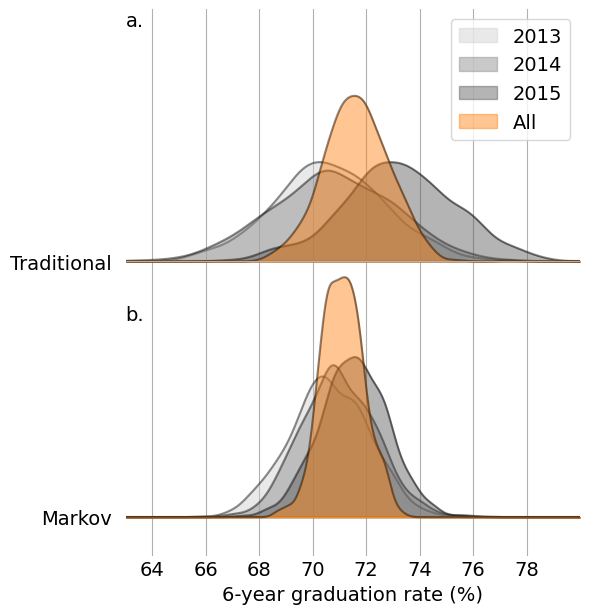

In [49]:
tmp = {"Traditional" : sygr_trad_bs, "Markov" : sygr_mark_bs}
for k in tmp.keys():
    if 2131 in tmp[k].keys():
        tmp[k]["2013"] = tmp[k][2131].copy()
        del tmp[k][2131]
        tmp[k]["2014"] = tmp[k][2141].copy()
        del tmp[k][2141]
        tmp[k]["2015"] = tmp[k][2151].copy()
        del tmp[k][2151]
        tmp[k]["All"] = tmp[k]["all"].copy()
        del tmp[k]["all"]

fig, ax = joypy.joyplot(tmp, color=["C9","C6","C3","C1"], alpha=0.45, overlap=.5, legend=True, 
                        grid=True, figsize=(6,6), xlabelsize=14, ylabelsize=14, x_range=[0.63,0.80])
ax[2].set_xlabel("6-year graduation rate (%)", fontsize=14)
ax[2].set_xticks(np.arange(0.64,0.78,0.02))
ax[2].set_xticklabels(list(range(64,80,2)))
ax[0].text(0.63,45,"a.",fontsize=14)
ax[2].text(0.63,0.43,"b.",fontsize=14)
ax[0].legend(fontsize=14);

<br>

---

## Results Section 2: Drill down to subsets of students, show that the biases from the traditional calculation are worse for these smaller groups (AALANA, first-gen, etc)

Three comparisons we can make, since RIT has been on semesters:
* Traditional (fall 2013 cohort, viewed in summer 2019) vs Markov (fall 2013-summer 2019 data)
* Traditional (fall 2014 cohort, viewed in summer 2020) vs Markov (fall 2014-summer 2020 data)
* Traditional (fall 2015 cohort, viewed in summer 2021) vs Markov (fall 2015-summer 2021 data)

Look at traditional vs Markov grad rates for:
* AALANA students
* first generation students
* female in COS

**Key Point: The biases between the traditional and Markov approaches are larger/less stable for smaller groups of students.** Demonstrated by the AALANA grad rate for 2151 not even being in the 95% CI from the 2131 cohort. (and the AALANA subgroup is the smallest, at about 30-40 students per cohort) 

The dispairity in grad rates between URM students and non-URM students is well-documented, and there are widespread efforts to address this issue. However, those efforts would be undermined if their efficacy is evaluated using biased metrics. Markov method provides greater confidence.

### AALANA students

#### Traditional:

In [50]:
sygr_trad_bs_aalana = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}
ID_beg1_trad = {ct : None for ct in cohort_terms}

dfSub = dfC.loc[dfC.AALANA=="AALANA"]
for ib in range(num_samples):    
    for ct in cohort_terms:
        ID_beg1_trad[ct] = dfSub.loc[(dfSub["Cohort Term"]==ct) & 
                                     (dfSub["Term"]>=ct) & (dfSub["Term"] < ct+10), "ID"].unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(ID_beg1_trad[ct], size=len(ID_beg1_trad[ct]), replace=True)) # bootstrap resample of the full data
        dfBS = dfSub.loc[dfSub.ID.isin(IDBS)].copy() # resampled data for just this cohort
        ID_grad = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
        sygr_trad_bs_aalana[ct][ib] = len(ID_grad)/len(IDBS)

    # overall:
    ID_beg1 = np.array(list(ID_beg1_trad[2131])+list(ID_beg1_trad[2141])+list(ID_beg1_trad[2151]))
    IDBS = np.unique(np.random.choice(ID_beg1, size=len(ID_beg1), replace=True)) # bootstrap resample of the full data
    dfBS = dfSub.loc[dfSub.ID.isin(IDBS)].copy() # resampled data for just this cohort
    ID_grad = dfBS.loc[(dfBS["Cohort Term"]==cohort_terms[0]) &
                       (dfBS["Degree Term"]>=cohort_terms[0]) &
                       (dfBS["Degree Term"]< cohort_terms[0]+60),"ID"].unique()
    if len(cohort_terms) > 1:
        for ct in cohort_terms[1:]:
            new = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
            ID_grad = list(set.union(set(ID_grad), set(new)))
    sygr_trad_bs_aalana["all"][ib] = len(ID_grad)/len(IDBS)

print("N =...")
for k in ID_beg1_trad.keys():
    print(k, len(ID_beg1_trad[k]))
print("All:",len(ID_beg1))


N =...
2131 31
2141 42
2151 34
All: 107


#### Markov:

In [51]:
sygr_mark_bs_aalana = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}

dfSub = dfC.loc[dfC.AALANA=="AALANA"]
for b in range(num_samples):
    nmats_com = {ct : None for ct in cohort_terms+["all"]}
    pmats_com = {ct : None for ct in cohort_terms+["all"]}

    # each cohort
    for ct in cohort_terms:
        dfSub_sub = dfSub.loc[(dfSub.Term >= ct) & (dfSub.Term < ct+60)] # what data would we have at the time?
        IDs_sub = dfSub_sub.ID.unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(IDs_sub, size=len(IDs_sub), replace=True)) # bootstrap resample of the full data
        dfBS = dfSub_sub.loc[dfSub_sub.ID.isin(IDBS)].copy() # resampled data for just this cohort term

        cohorts = [ct,ct+10,ct+20,ct+30,ct+40]
        nmats = {c : None for c in cohorts+["all"]}
        pmats = {c : None for c in cohorts+["all"]}
        for c in cohorts:
            nmats[c] = compute_matrix_las(dfBS,c)
            pmats[c] = normalize(nmats[c])
        nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
        pmats["all"] = normalize(nmats["all"])
        sygr_mark_bs_aalana[ct][b] = np.linalg.matrix_power(pmats["all"],6)[0,7]
        nmats_com[ct] = nmats["all"]
        pmats_com[ct] = normalize(nmats_com[ct])

    # combined
    nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
    pmats_com["all"] = normalize(nmats_com["all"])
    sygr_mark_bs_aalana["all"][b] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]


Table 4, top part:

In [52]:
for ct in sygr_trad_bs_aalana.keys():
    prcs_trad = np.percentile(sygr_trad_bs_aalana[ct], [(100-conf)/2,50,100-(100-conf)/2])
    prcs_mark = np.percentile(sygr_mark_bs_aalana[ct], [(100-conf)/2,50,100-(100-conf)/2])
    print(ct, "TRAD:", np.round(prcs_trad, 3), np.round(np.diff(prcs_trad[[0,2]]),3))
    print(ct, "MARK:", np.round(prcs_mark, 3), np.round(np.diff(prcs_mark[[0,2]]),3))
    print(ct, "% change in CI width:",np.round((np.diff(prcs_mark[[0,2]])-np.diff(prcs_trad[[0,2]]))/np.diff(prcs_trad[[0,2]]),3))
    print("")

2131 TRAD: [0.4   0.55  0.684] [0.284]
2131 MARK: [0.54  0.619 0.706] [0.167]
2131 % change in CI width: [-0.414]

2141 TRAD: [0.48  0.593 0.704] [0.224]
2141 MARK: [0.567 0.644 0.734] [0.167]
2141 % change in CI width: [-0.252]

2151 TRAD: [0.591 0.702 0.826] [0.235]
2151 MARK: [0.619 0.692 0.767] [0.149]
2151 % change in CI width: [-0.367]

all TRAD: [0.551 0.618 0.687] [0.136]
all MARK: [0.611 0.653 0.702] [0.091]
all % change in CI width: [-0.328]



Notably, the 2131 traditional grad rate estimate's CI (38-68%) doesn't even include the 2151 traditional grad rate (71%), and the 2141 just barely does.

In [77]:
Figure 2, left part

SyntaxError: invalid syntax (2076352488.py, line 1)

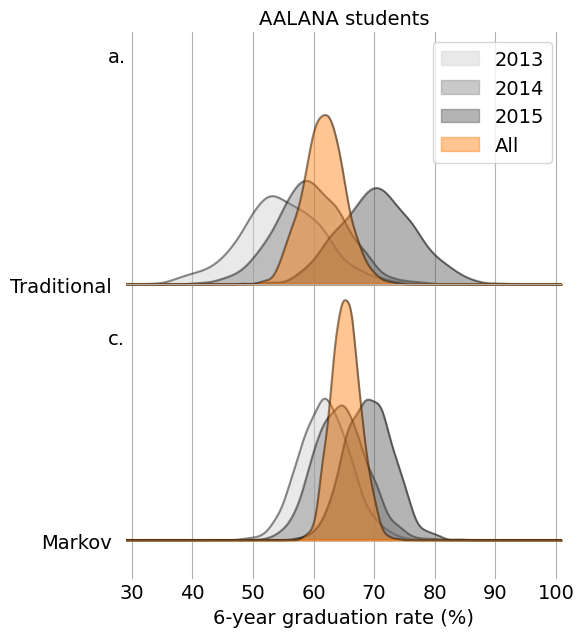

In [53]:
tmp = {"Traditional" : sygr_trad_bs_aalana, "Markov" : sygr_mark_bs_aalana}
for k in tmp.keys():
    if 2131 in tmp[k].keys():
        tmp[k]["2013"] = tmp[k][2131].copy()
        del tmp[k][2131]
        tmp[k]["2014"] = tmp[k][2141].copy()
        del tmp[k][2141]
        tmp[k]["2015"] = tmp[k][2151].copy()
        del tmp[k][2151]
        tmp[k]["All"] = tmp[k]["all"].copy()
        del tmp[k]["all"]

fig, ax = joypy.joyplot(tmp, color=["C9","C6","C3","C1"], alpha=0.45, overlap=.5, legend=True, 
                        grid=True, figsize=(6,6), xlabelsize=14, ylabelsize=14, x_range=[0.29,1.01])
ax[2].set_xlabel("6-year graduation rate (%)", fontsize=14)
ax[2].set_xticks(np.arange(0.3,1.1,0.1))
ax[2].set_xticklabels(list(range(30,110,10)))
ax[0].set_title("AALANA students", fontsize=14)
ax[0].text(0.26,15,"a.",fontsize=14)
ax[2].text(0.26,0.43,"c.",fontsize=14)
ax[0].legend(fontsize=14);

### First generation students

#### Traditional:

In [54]:
sygr_trad_bs_firstgen = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}
ID_beg1_trad = {ct : None for ct in cohort_terms}

dfSub = dfC.loc[dfC["First Generation"]=="First Gen"]
for ib in range(num_samples):    
    for ct in cohort_terms:
        ID_beg1_trad[ct] = dfSub.loc[(dfSub["Cohort Term"]==ct) & 
                                     (dfSub["Term"]>=ct) & (dfSub["Term"] < ct+10), "ID"].unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(ID_beg1_trad[ct], size=len(ID_beg1_trad[ct]), replace=True)) # bootstrap resample of the full data
        dfBS = dfSub.loc[dfSub.ID.isin(IDBS)].copy() # resampled data for just this cohort
        ID_grad = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
        sygr_trad_bs_firstgen[ct][ib] = len(ID_grad)/len(IDBS)

    # overall:
    ID_beg1 = np.array(list(ID_beg1_trad[2131])+list(ID_beg1_trad[2141])+list(ID_beg1_trad[2151]))
    IDBS = np.unique(np.random.choice(ID_beg1, size=len(ID_beg1), replace=True)) # bootstrap resample of the full data
    dfBS = dfSub.loc[dfSub.ID.isin(IDBS)].copy() # resampled data for just this cohort
    ID_grad = dfBS.loc[(dfBS["Cohort Term"]==cohort_terms[0]) &
                       (dfBS["Degree Term"]>=cohort_terms[0]) &
                       (dfBS["Degree Term"]< cohort_terms[0]+60),"ID"].unique()
    if len(cohort_terms) > 1:
        for ct in cohort_terms[1:]:
            new = dfBS.loc[(dfBS["Cohort Term"]==ct) &
                           (dfBS["Degree Term"]>=ct) &
                           (dfBS["Degree Term"]< ct+60),"ID"].unique()
            ID_grad = list(set.union(set(ID_grad), set(new)))
    sygr_trad_bs_firstgen["all"][ib] = len(ID_grad)/len(IDBS)

print("N =...")
for k in ID_beg1_trad.keys():
    print(k, len(ID_beg1_trad[k]))
print("All:",len(ID_beg1))


N =...
2131 54
2141 51
2151 64
All: 169


#### Markov:

In [55]:
sygr_mark_bs_firstgen = {ct : np.zeros(num_samples) for ct in cohort_terms+["all"]}

dfSub = dfC.loc[dfC["First Generation"]=="First Gen"]
for b in range(num_samples):
    nmats_com = {ct : None for ct in cohort_terms+["all"]}
    pmats_com = {ct : None for ct in cohort_terms+["all"]}

    # each cohort
    for ct in cohort_terms:
        dfSub_sub = dfSub.loc[(dfSub.Term >= ct) & (dfSub.Term < ct+60)] # what data would we have at the time?
        IDs_sub = dfSub_sub.ID.unique() # who all is in the full data set?
        IDBS = np.unique(np.random.choice(IDs_sub, size=len(IDs_sub), replace=True)) # bootstrap resample of the full data
        dfBS = dfSub_sub.loc[dfSub_sub.ID.isin(IDBS)].copy() # resampled data for just this cohort term

        cohorts = [ct,ct+10,ct+20,ct+30,ct+40]
        nmats = {c : None for c in cohorts+["all"]}
        pmats = {c : None for c in cohorts+["all"]}
        for c in cohorts:
            nmats[c] = compute_matrix_las(dfBS,c)
            pmats[c] = normalize(nmats[c])
        nmats["all"] = np.sum([nmats[c] for c in cohorts], axis=0)
        pmats["all"] = normalize(nmats["all"])
        sygr_mark_bs_firstgen[ct][b] = np.linalg.matrix_power(pmats["all"],6)[0,7]
        nmats_com[ct] = nmats["all"]
        pmats_com[ct] = normalize(nmats_com[ct])

    # combined
    nmats_com["all"] = np.sum([nmats_com[ct] for ct in cohort_terms], axis=0)
    pmats_com["all"] = normalize(nmats_com["all"])
    sygr_mark_bs_firstgen["all"][b] = np.linalg.matrix_power(pmats_com["all"],6)[0,7]


Table 4, bottom part:

In [56]:
for ct in sygr_trad_bs_firstgen.keys():
    prcs_trad = np.percentile(sygr_trad_bs_firstgen[ct], [(100-conf)/2,50,100-(100-conf)/2])
    prcs_mark = np.percentile(sygr_mark_bs_firstgen[ct], [(100-conf)/2,50,100-(100-conf)/2])
    print(ct, "TRAD:", np.round(prcs_trad, 3), np.round(np.diff(prcs_trad[[0,2]]),3))
    print(ct, "MARK:", np.round(prcs_mark, 3), np.round(np.diff(prcs_mark[[0,2]]),3))
    print(ct, "% change in CI width:",np.round((np.diff(prcs_mark[[0,2]])-np.diff(prcs_trad[[0,2]]))/np.diff(prcs_trad[[0,2]]),3))
    print("")

2131 TRAD: [0.611 0.703 0.806] [0.194]
2131 MARK: [0.643 0.7   0.756] [0.113]
2131 % change in CI width: [-0.42]

2141 TRAD: [0.571 0.667 0.767] [0.195]
2141 MARK: [0.612 0.683 0.759] [0.147]
2141 % change in CI width: [-0.246]

2151 TRAD: [0.634 0.718 0.805] [0.171]
2151 MARK: [0.65  0.699 0.752] [0.103]
2151 % change in CI width: [-0.399]

all TRAD: [0.643 0.697 0.748] [0.105]
all MARK: [0.665 0.697 0.73 ] [0.065]
all % change in CI width: [-0.377]



Figure 2, right part

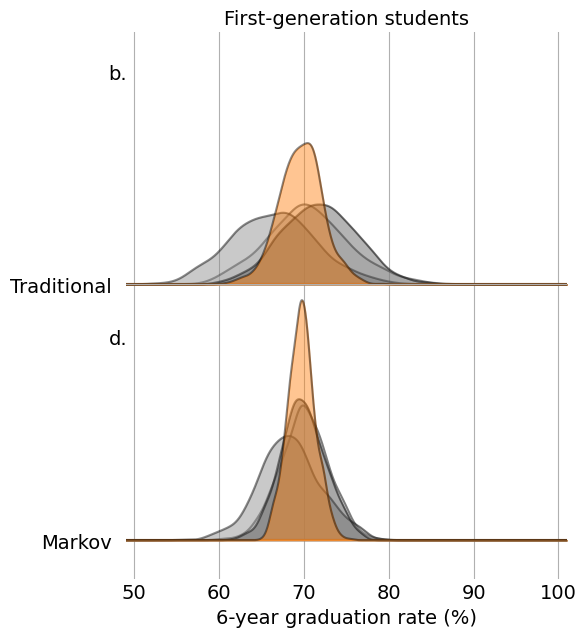

In [57]:
tmp = {"Traditional" : sygr_trad_bs_firstgen, "Markov" : sygr_mark_bs_firstgen}
for k in tmp.keys():
    if 2131 in tmp[k].keys():
        tmp[k]["2013"] = tmp[k][2131].copy()
        del tmp[k][2131]
        tmp[k]["2014"] = tmp[k][2141].copy()
        del tmp[k][2141]
        tmp[k]["2015"] = tmp[k][2151].copy()
        del tmp[k][2151]
        tmp[k]["All"] = tmp[k]["all"].copy()
        del tmp[k]["all"]

fig, ax = joypy.joyplot(tmp, color=["C9","C6","C3","C1"], alpha=0.45, overlap=.5, legend=False, 
                        grid=True, figsize=(6,6), xlabelsize=14, ylabelsize=14, x_range=[0.49,1.01])
ax[2].set_xlabel("6-year graduation rate (%)", fontsize=14)
ax[2].set_xticks(np.arange(0.5,1.01,0.1))
ax[2].set_xticklabels(list(range(50,110,10)))
ax[0].set_title("First-generation students", fontsize=14)
ax[0].text(0.47,22,"b.",fontsize=14)
ax[2].text(0.47,0.43,"d.",fontsize=14);
#ax[0].legend(fontsize=14);

<br>

---

## Results Section 3: LA-having vs non-LA-having students (irregularly applied intervention)

Compute traditional for each of the fall 2013, 2014, and 2015 cohorts, and compare to the Markov model estimate from summer 2021. Highlight the improvement from having LAs.

In [58]:
cohort_terms = cohort_terms_full+cohort_terms_part

def matrices_for_course_list(courses, LAclass_tups, df, cohort_terms):
    # input: courses (list of (SUBJ, CRS#) tuples), LAclass_tups, df, list of terms to use

    IDs_these_courses, IDs_LAs_these_courses = set(), set()
    LA_tups_these_courses = []
    for c in courses:
        IDs_these_courses = set.union(IDs_these_courses,
                                      df.loc[(df.subject==c[0]) & (df.catalog_nbr==c[1]),"ID"].unique())
        this_class = [LAclass_tups[k][0]==c[0] and LAclass_tups[k][1]==c[1] for k in range(len(LAclass_tups))]
        if np.sum(this_class) > 0:
            LA_tups_this_class = [LAclass_tups[k] for k in [i for i, x in enumerate(this_class) if x]]
            LA_tups_these_courses = LA_tups_these_courses + list(LA_tups_this_class)
            for cs in LA_tups_this_class:
                IDs_LAs_these_courses = set.union(IDs_LAs_these_courses,
                                                  df.loc[(df.subject==cs[0]) & (df.catalog_nbr==cs[1]) & 
                                                         (df.class_section==cs[2]) & (df.Term==cs[3]),"ID"].unique())
    # restrict to only the list of courses
    dfC_all = df.loc[(df.ID.isin(IDs_these_courses))]
    dfC_LA = df.loc[(df.ID.isin(IDs_LAs_these_courses))]
    dfC_noLA = df.loc[(~df.ID.isin(IDs_LAs_these_courses))]

    # numbers matrices for these courses
    mats_LA_these_courses = {c : None for c in cohort_terms}
    mats_noLA_these_courses = {c : None for c in cohort_terms}
    for c in cohort_terms:
        mats_LA_these_courses[c] = compute_matrix_las(dfC_LA,c,True,False)
        mats_noLA_these_courses[c] = compute_matrix_las(dfC_noLA,c)

    # sum across cohort terms and normalize    
    mats_LA_these_courses["all"] = np.sum([mats_LA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_LA_these_courses = normalize(mats_LA_these_courses["all"])
    mats_noLA_these_courses["all"] = np.sum([mats_noLA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_noLA_these_courses = normalize(mats_noLA_these_courses["all"])

    return (pmats_LA_these_courses, pmats_noLA_these_courses, \
            mats_LA_these_courses, mats_noLA_these_courses, \
            IDs_LAs_these_courses, IDs_these_courses)

In [59]:
def bootstrap_markov(N, courses, LAclass_tups, df, ct, get=6):
    '''
    get : 1, 4, or 6 -step transition rate (Y1 retention, or 4-/6-year grad rate)
    '''
    rate_LA, rate_noLA = np.zeros(N), np.zeros(N)
    if get==1:
        return_col = 1
    else:
        return_col = 7
    if type(ct)!=list:
        ctl = [ct]
    else:
        ctl = ct
    for i in range(N):
        # get a bootstrap resample
        IDs = df.ID.unique()
        IDBS = np.unique(np.random.choice(IDs, size=len(IDs), replace=True))
        dfBS = df.loc[df.ID.isin(IDBS)].copy()
        # compute transition matrices
        pmat_LA, pmat_noLA, mats_LA, \
        mats_noLA, IDs_LA, IDs_all = matrices_for_course_list(courses, LAclass_tups, dfBS, ctl)
        # compute grad/retention rates
        newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA,get), np.linalg.matrix_power(pmat_noLA,get)
        rate_LA[i] = newmats_LA[0,return_col]
        rate_noLA[i] = newmats_noLA[0,return_col]
    return rate_LA, rate_noLA

<br>

### High-DFW COS courses

Including:
* PHYS: 111, 112, 211A, 211, 212
* MATH: 111, 171, 182A, 211
  * Note that there are no instances of MATH 172, 181(A), or 182 using LAs.
  * There is a single instance of MATH 182A using an LA.
  * Results without MATH 211 is below this. However, there's an overall DFW rate of 25% in that course, between Fall 2013 and Fall 2019 (see further below)

### COS students overall

using `dfC` now, so already looking only at COS students

In [60]:
courses = [("PHYS","111"),("PHYS","112"),("PHYS","211"),("PHYS","211A"),("PHYS","212"),
           ("MATH","111"), ("MATH","171"),("MATH","182A"),("MATH","211")]
sygr_LA = {k : None for k in cohort_terms_full+["all"]}
sygr_noLA = {k : None for k in cohort_terms_full+["all"]}

tbeg = time()
for ct in cohort_terms_full:
    sygr_LA[ct], sygr_noLA[ct] = bootstrap_markov(num_samples,courses,LAclass_tups,dfC,ct,6)

sygr_LA["all"], sygr_noLA["all"] = bootstrap_markov(num_samples,courses,LAclass_tups,dfC,cohort_terms,6)
tend = time()
print("Took",(tend-tbeg)/60,"minutes")

Took 80.78238938649496 minutes


Reporting just the "all" case, since the other results would mirror what we saw previously.

### COS, AALANA students

In [61]:
sygr_LA_aalana = {k : None for k in cohort_terms_full+["all"]}
sygr_noLA_aalana = {k : None for k in cohort_terms_full+["all"]}

dfSub = dfC.loc[dfC["AALANA"]=="AALANA"]
#dfSub = dfC.loc[dfC["First Generation"]=="First Gen"]
tbeg = time()
for ct in cohort_terms_full:
    sygr_LA_aalana[ct], sygr_noLA_aalana[ct] = bootstrap_markov(num_samples,courses,LAclass_tups,dfSub,ct,6)

sygr_LA_aalana["all"], sygr_noLA_aalana["all"] = bootstrap_markov(num_samples,courses,LAclass_tups,dfSub,cohort_terms,6)
tend = time()
print("Took",(tend-tbeg)/60,"minutes")

Took 15.626939964294433 minutes


**Key point:** differences are more substantial for URM groups

### COS, first generation students

In [62]:
sygr_LA_firstgen = {k : None for k in cohort_terms_full+["all"]}
sygr_noLA_firstgen = {k : None for k in cohort_terms_full+["all"]}

dfSub = dfC.loc[dfC["First Generation"]=="First Gen"]
tbeg = time()
for ct in cohort_terms_full:
    sygr_LA_firstgen[ct], sygr_noLA_firstgen[ct] = bootstrap_markov(num_samples,courses,LAclass_tups,dfSub,ct,6)

sygr_LA_firstgen["all"], sygr_noLA_firstgen["all"] = bootstrap_markov(num_samples,courses,LAclass_tups,dfSub,cohort_terms,6)
tend = time()
print("Took",(tend-tbeg)/60,"minutes")

Took 19.57738018433253 minutes


### Combine all 3 of these into a single figure

In [63]:
kdes_all = {"noLA" : stats.gaussian_kde(sygr_noLA["all"]), 
            "LA"   : stats.gaussian_kde(sygr_LA["all"])}
prcs_all = {"noLA" : np.percentile(sygr_noLA["all"], [(100-conf)/2,50,100-(100-conf)/2]),
            "LA"   : np.percentile(sygr_LA["all"], [(100-conf)/2,50,100-(100-conf)/2])}

kdes_aalana = {"noLA" : stats.gaussian_kde(sygr_noLA_aalana["all"]), 
               "LA"   : stats.gaussian_kde(sygr_LA_aalana["all"])}
prcs_aalana = {"noLA" : np.percentile(sygr_noLA_aalana["all"], [(100-conf)/2,50,100-(100-conf)/2]),
               "LA"   : np.percentile(sygr_LA_aalana["all"], [(100-conf)/2,50,100-(100-conf)/2])}

kdes_firstgen = {"noLA" : stats.gaussian_kde(sygr_noLA_firstgen["all"]), 
                 "LA"   : stats.gaussian_kde(sygr_LA_firstgen["all"])}
prcs_firstgen = {"noLA" : np.percentile(sygr_noLA_firstgen["all"], [(100-conf)/2,50,100-(100-conf)/2]),
                 "LA"   : np.percentile(sygr_LA_firstgen["all"], [(100-conf)/2,50,100-(100-conf)/2])}

Figure 3

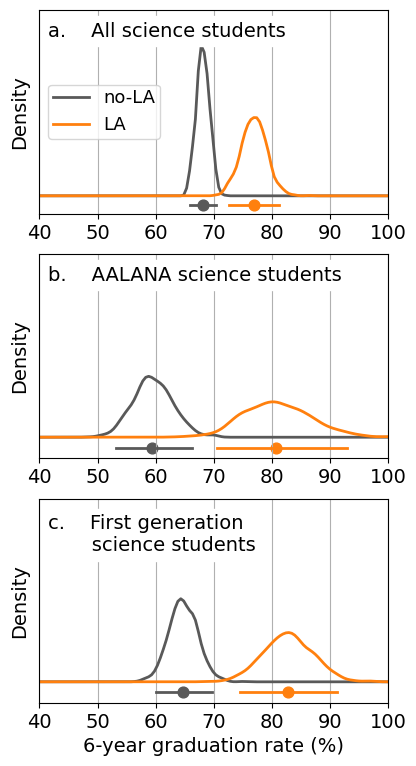

In [64]:
fig,ax = plt.subplots(3,1,figsize=(4.5,9))
x = np.linspace(start=0,stop=1,num=200)

i=0 # All
ax[i].plot(x, kdes_all["noLA"].pdf(x), linewidth=2, color="C3", label="no-LA")
ax[i].plot(x, kdes_all["LA"].pdf(x), linewidth=2, color="C1", label="LA")
ax[i].set_xlim([0.4,1]); 
ax[i].set_xticks([.4,.5,.6,.7,.8,.9,1]); 
ax[i].set_xticklabels(list(range(40,110,10)), fontsize=14)
ax[i].set_ylabel("Density", fontsize=14); ax[i].set_yticks([]); ax[i].set_ylim([-4,42])
ax[i].plot([prcs_all["noLA"][0], prcs_all["noLA"][2]], [-2,-2], linewidth=2, color="C3")
ax[i].scatter(prcs_all["noLA"][1], -2, color="C3", s=60)
ax[i].plot([prcs_all["LA"][0], prcs_all["LA"][2]],   [-2,-2], linewidth=2, color="C1")
ax[i].scatter(prcs_all["LA"][1], -2, color="C1", s=60)
ax[i].text(.415,36,"a.    All science students", fontsize=14, backgroundcolor="white")
ax[i].legend(loc=6, fontsize=13, borderpad=.25); ax[i].grid()
i=1 # AALANA
ax[i].plot(x, kdes_aalana["noLA"].pdf(x), linewidth=2, color="C3", label="no-LA")
ax[i].plot(x, kdes_aalana["LA"].pdf(x), linewidth=2, color="C1", label="LA")
ax[i].set_xlim([0.4,1]); ax[i].set_xticks([.4,.5,.6,.7,.8,.9,1]); 
ax[i].set_xticklabels(list(range(40,110,10)), fontsize=14)
ax[i].set_ylabel("Density", fontsize=14); ax[i].set_yticks([]); ax[i].set_ylim([-4,35])
ax[i].plot([prcs_aalana["noLA"][0], prcs_aalana["noLA"][2]], [-2,-2], linewidth=2, color="C3")
ax[i].scatter(prcs_aalana["noLA"][1], -2, color="C3", s=60)
ax[i].plot([prcs_aalana["LA"][0], prcs_aalana["LA"][2]],   [-2,-2], linewidth=2, color="C1")
ax[i].scatter(prcs_aalana["LA"][1], -2, color="C1", s=60)
ax[i].text(.415,30,"b.    AALANA science students", fontsize=14, backgroundcolor="white")
ax[i].grid()
i=2 # First-gen
ax[i].plot(x, kdes_firstgen["noLA"].pdf(x), linewidth=2, color="C3", label="no-LA")
ax[i].plot(x, kdes_firstgen["LA"].pdf(x), linewidth=2, color="C1", label="LA")
ax[i].set_xlim([0.4,1]); ax[i].set_xticks([.4,.5,.6,.7,.8,.9,1]); 
ax[i].set_xticklabels(list(range(40,110,10)), fontsize=14)
ax[i].set_ylabel("Density", fontsize=14); ax[i].set_yticks([]); ax[i].set_ylim([-4,35])
ax[i].plot([prcs_firstgen["noLA"][0], prcs_firstgen["noLA"][2]], [-2,-2], linewidth=2, color="C3")
ax[i].scatter(prcs_firstgen["noLA"][1], -2, color="C3", s=60)
ax[i].plot([prcs_firstgen["LA"][0], prcs_firstgen["LA"][2]],   [-2,-2], linewidth=2, color="C1")
ax[i].scatter(prcs_firstgen["LA"][1], -2, color="C1", s=60)
ax[i].text(.415,25,"c.    First generation\n       science students", fontsize=14, backgroundcolor="white")
ax[i].grid()
#
ax[i].set_xlabel("6-year graduation rate (%)", fontsize=14);

In [65]:
prcs_all["noLA"][1]-prcs_aalana["noLA"][1]

0.08691986732475332

In [66]:
prcs_all["LA"][1] - prcs_aalana["LA"][1]

-0.038014056983978084

In [67]:
prcs_all

{'noLA': array([0.6596791 , 0.68122216, 0.70308994]),
 'LA': array([0.72581487, 0.7693787 , 0.81270399])}

In [68]:
prcs_all["LA"][1]-prcs_all["noLA"][1]

0.08815654507342174

In [69]:
prcs_aalana

{'noLA': array([0.53107841, 0.59430229, 0.66324785]),
 'LA': array([0.70612202, 0.80739276, 0.92857143])}

In [70]:
prcs_aalana["LA"][1]-prcs_aalana["noLA"][1]

0.21309046938215315

In [71]:
prcs_firstgen

{'noLA': array([0.60009792, 0.64677891, 0.69613543]),
 'LA': array([0.74514041, 0.82773014, 0.91188144])}

In [72]:
prcs_firstgen["LA"][1]-prcs_firstgen["noLA"][1]

0.18095122996567292

**Key Point:** LAs are a path to equity in outcomes. No overlap (or minimal?) between CIs for no-LA all vs no-LA AALANA students. But no statistically significant difference (overlapping CIs) for the all group and AALANA and First-gen students with LAs.

<br>

## Year-to-year retention/persistence rates

SOM tables 2-4

In [73]:
### COS students overall
pmat_LA_all, pmat_noLA_all, \
mats_LA_all, mats_noLA_all, \
IDs_LA_all, IDs_all_all = matrices_for_course_list(courses, LAclass_tups, dfC, cohort_terms)
### AALANA COS students
pmat_LA_aalana, pmat_noLA_aalana, \
mats_LA_aalana, mats_noLA_aalana, \
IDs_LA_aalana, IDs_all_aalana = matrices_for_course_list(courses, LAclass_tups, dfC.loc[dfC.AALANA=="AALANA"], cohort_terms)
### First gen COS students
pmat_LA_firstgen, pmat_noLA_firstgen, \
mats_LA_firstgen, mats_noLA_firstgen, \
IDs_LA_firstgen, IDs_all_firstgen = matrices_for_course_list(courses, LAclass_tups, dfC.loc[dfC["First Generation"]=="First Gen"], cohort_terms)


In [74]:
print("OVERALL:")
print("      no-LA   LA     Diff")
print("---------------------------")
for y in range(3):
    print("Y{}-{}: {:0.4f} {:0.4f} {:0.4f}".format(
        y+1,y+2,pmat_noLA_all[y,y+1], pmat_LA_all[y,y+1], pmat_LA_all[y,y+1]-pmat_noLA_all[y,y+1]))
    

OVERALL:
      no-LA   LA     Diff
---------------------------
Y1-2: 0.8661 0.9512 0.0851
Y2-3: 0.9080 0.9265 0.0185
Y3-4: 0.9072 0.9345 0.0273


In [75]:
print("AALANA:")
print("      no-LA   LA     Diff")
print("---------------------------")
for y in range(3):
    print("Y{}-{}: {:0.4f} {:0.4f} {:0.4f}".format(
        y+1,y+2,pmat_noLA_aalana[y,y+1], pmat_LA_aalana[y,y+1], pmat_LA_aalana[y,y+1]-pmat_noLA_aalana[y,y+1]))
    

AALANA:
      no-LA   LA     Diff
---------------------------
Y1-2: 0.8351 0.9231 0.0880
Y2-3: 0.8849 0.9211 0.0362
Y3-4: 0.8857 0.9394 0.0537


In [76]:
print("First-gen:")
print("      no-LA   LA     Diff")
print("---------------------------")
for y in range(3):
    print("Y{}-{}: {:0.4f} {:0.4f} {:0.4f}".format(
        y+1,y+2,pmat_noLA_firstgen[y,y+1], pmat_LA_firstgen[y,y+1], pmat_LA_firstgen[y,y+1]-pmat_noLA_firstgen[y,y+1]))
    

First-gen:
      no-LA   LA     Diff
---------------------------
Y1-2: 0.8617 0.9565 0.0948
Y2-3: 0.9018 0.9298 0.0280
Y3-4: 0.9045 0.9149 0.0104


<br>

---

# old stuff below here

---

<br>

not only COS students here:

In [106]:
courses = [("PHYS","111"),("PHYS","112"),("PHYS","211"),("PHYS","211A"),("PHYS","212"),
           ("MATH","111"), ("MATH","171"),("MATH","182A"),("MATH","211")]
pmat_LA_dfw, pmat_noLA_dfw, mats_LA_dfw, mats_noLA_dfw = matrices_for_course_list(courses,
                                                                                  LAclass_tups, dfC, cohort_terms)
# Y1 retention
printmat(pmat_LA_dfw)
printmat(pmat_noLA_dfw)
# 4-year grad rate
n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))
# 6-year grad rate
n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n", int(mats_LA_dfw["all"][0,1]), "students starting in Y1 with LA in a high-DFW COS course")

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.946      0.054         0.0
2    0.936      0.063       0.001
3     0.96      0.031       0.009
4    0.811      0.022       0.168
5    0.215       0.04       0.745
6                0.32        0.68
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.866      0.134         0.0
2    0.911      0.087       0.002
3     0.93      0.043       0.027
4    0.532      0.029       0.439
5    0.236      0.028       0.736
6               0.346       0.654
LAs:
 [0.     0.     0.     0.     0.6892 0.     0.1598 0.151 ]
No LAs:
 [0.     0.     0.     0.     0.3907 0.     0.2643 0.3449]
4Y graduate rate among LA-having high-DFW COS course students 0.151
4Y graduate rate among high-DFW COS course students w/ no LAs 0.345
LAs:
 [0.     0.     0.     0.     0.     0.     0.2345 0.7655]
No LAs:
 [0.     0.     0.     0.     0.     0.     0.3071 0.6929]
6Y graduate rate among LA-having high-DFW COS course s

<h2 style="color:blue;font-size:24pt">Now breaking it up by LA-having students and non-LA-having students</h2>

* `dfLAcoursestudents_LA` is the dataframe with only entries for students who have had LAs at some point in their time at RIT
  * as a reminder, this is adding students to the analysis starting with the AY in which they have an LA. So, if someone from the Fall 2013 cohort has an LA during Spring 2015 (spring of their second year), they are used in the Y2->Y3 transition calculations, and all subsequent transitions
* `dfLAcoursestudents_noLA` is the dataframe with only entries for students who never had LAs during their time at RIT, but did take a non-LA version of a course that has/has had LA assistance at some point

In [279]:
# students who ever took a course that has LA-assisted sections
dfLAcoursestudents = df.loc[df.LAclass_students==1]
# ... out of those students, who had an LA experience at this point or earlier?
dfLAcoursestudents_LA = dfLAcoursestudents.loc[dfLAcoursestudents.LAexperience==1]
# ... out of those students, who never had an LA experience ever?
dfLAcoursestudents_noLA = dfLAcoursestudents.loc[(~dfLAcoursestudents.ID.isin(LA_students_dict.keys()))]

How many LA-having and non-LA-having students are there, who have ever taken an LA-assisted course?

In [280]:
len(dfLAcoursestudents_LA["ID"].unique()), len(dfLAcoursestudents_noLA["ID"].unique())

(11258, 19361)

### How many transfer students among the students in LA-assisted courses?

Estimating based on students' first `Term` being greater than their `Cohort Term`

In [43]:
IDs_transfer = set()
print("Cohort Term  N_transfer  N_total")
print("--------------------------------")
for t in cohort_terms_full+cohort_terms_part:
    IDs_this_cohort_term = dfLAcoursestudents.loc[(dfLAcoursestudents["Cohort Term"]==t) & 
                                                  (dfLAcoursestudents["Term"] < t),"ID"].unique()
    IDs_transfer = set.union(IDs_transfer, IDs_this_cohort_term)
    N_cohort = len(dfLAcoursestudents.loc[(dfLAcoursestudents["Cohort Term"]==t),"ID"].unique())
    print(f"{int(t):>11}",f"{int(len(IDs_this_cohort_term)):>10}  ",f"{int(N_cohort):>6}")
    

Cohort Term  N_transfer  N_total
--------------------------------
       2131          0     2629
       2141         70     2492
       2151         72     2713
       2161         63     2390
       2171         51     2460
       2181         34     2452
       2191         34     2366


### Enumerate how many LA-having students are Y1, Y2, etc. each academic term

In [44]:
#                  fall terms             +         spring terms
terms = np.sort(list(range(2131,2211,10)) + list(range(2135,2215,10)))
prc_LAstudents = np.zeros((6,len(terms))) # columns are terms, rows are different years [y1-y6]
num_LAstudents = np.zeros((6,len(terms))) # columns are terms, rows are different years [y1-y6]

LAclasses_each_term = {t : None for t in terms}
for t in terms:
    # which classes had LAs this term?
    LAclasses_each_term[t] = [LAclass_tups[k] for k in range(len(LAclass_tups)) if LAclass_tups[k][3]==t]
    # figure out who all had LAs this semester
    LAstudent_IDs_this_term = set()
    for c in LAclasses_each_term[t]:
        IDs_LAstudents = dfLAcoursestudents.loc[(dfLAcoursestudents.subject==c[0]) & 
                                                (dfLAcoursestudents.catalog_nbr==c[1]) &
                                                (dfLAcoursestudents.class_section==c[2]) &
                                                (dfLAcoursestudents.Term==c[3]), "ID"].unique()
        LAstudent_IDs_this_term = set.union(LAstudent_IDs_this_term, IDs_LAstudents)
    # of those who had LAs, how many are in Y1 (cohort year == this year), Y2, etc.
    LAstudent_IDs_this_term = list(LAstudent_IDs_this_term)
    num_total = len(LAstudent_IDs_this_term)
    dfTerm = dfLAcoursestudents.loc[(dfLAcoursestudents.ID.isin(LAstudent_IDs_this_term)) &
                                    (dfLAcoursestudents.Term==t),
                                    ["ID","Cohort Term","Term","Acad Plan","College"]].drop_duplicates(subset="ID")
    dfTerm["Term Offset"] = dfTerm["Term"] - dfTerm["Cohort Term"]
    num_Y1 = dfTerm.loc[(dfTerm["Term Offset"] >= 0 ) & (dfTerm["Term Offset"] < 10),"ID"].count()
    num_Y2 = dfTerm.loc[(dfTerm["Term Offset"] >= 10) & (dfTerm["Term Offset"] < 20),"ID"].count()
    num_Y3 = dfTerm.loc[(dfTerm["Term Offset"] >= 20) & (dfTerm["Term Offset"] < 30),"ID"].count()
    num_Y4 = dfTerm.loc[(dfTerm["Term Offset"] >= 30) & (dfTerm["Term Offset"] < 40),"ID"].count()
    num_Y5 = dfTerm.loc[(dfTerm["Term Offset"] >= 40) & (dfTerm["Term Offset"] < 50),"ID"].count()
    num_Y6 = dfTerm.loc[(dfTerm["Term Offset"] >= 50) & (dfTerm["Term Offset"] < 60),"ID"].count()
    num_total_cohortvalid = num_Y1+num_Y2+num_Y3+num_Y4+num_Y5+num_Y6
    num_LAstudents[:,terms==t] = np.transpose(np.array([[num_Y1, num_Y2, num_Y3, num_Y4, num_Y5, num_Y6]]))
    prc_LAstudents[:,terms==t] = num_LAstudents[:,terms==t]/num_total_cohortvalid

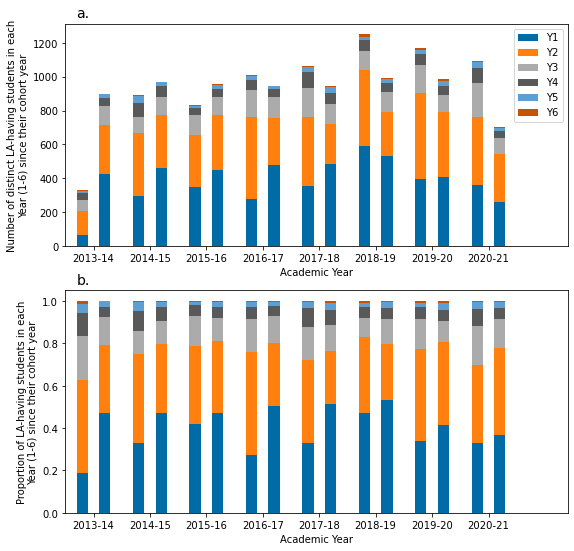

In [45]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(9,9))
ax[0].bar(terms,num_LAstudents[0,:], width=2, label="Y1")
ax[0].bar(terms,num_LAstudents[1,:],bottom=np.sum(num_LAstudents[:1,:],0), width=2, label="Y2")
ax[0].bar(terms,num_LAstudents[2,:],bottom=np.sum(num_LAstudents[:2,:],0), width=2, label="Y3")
ax[0].bar(terms,num_LAstudents[3,:],bottom=np.sum(num_LAstudents[:3,:],0), width=2, label="Y4")
ax[0].bar(terms,num_LAstudents[4,:],bottom=np.sum(num_LAstudents[:4,:],0), width=2, label="Y5")
ax[0].bar(terms,num_LAstudents[5,:],bottom=np.sum(num_LAstudents[:5,:],0), width=2, label="Y6")
ax[0].set_xlim([2128,2217]); ax[0].legend()
ax[0].set_xticks([2133,2143,2153,2163,2173,2183,2193,2203])
ax[0].set_xticklabels(["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"])
ax[0].set_xlabel("Academic Year");
ax[0].set_ylabel("Number of distinct LA-having students in each\nYear (1-6) since their cohort year");
ax[0].text(2130,1350,"a.",fontsize=14);

ax[1].bar(terms,prc_LAstudents[0,:], width=2, label="Y1")
ax[1].bar(terms,prc_LAstudents[1,:],bottom=np.sum(prc_LAstudents[:1,:],0), width=2, label="Y2")
ax[1].bar(terms,prc_LAstudents[2,:],bottom=np.sum(prc_LAstudents[:2,:],0), width=2, label="Y3")
ax[1].bar(terms,prc_LAstudents[3,:],bottom=np.sum(prc_LAstudents[:3,:],0), width=2, label="Y4")
ax[1].bar(terms,prc_LAstudents[4,:],bottom=np.sum(prc_LAstudents[:4,:],0), width=2, label="Y5")
ax[1].bar(terms,prc_LAstudents[5,:],bottom=np.sum(prc_LAstudents[:5,:],0), width=2, label="Y6")
ax[1].set_xlim([2128,2217]); #ax[1].legend();
ax[1].set_xticks([2133,2143,2153,2163,2173,2183,2193,2203])
ax[1].set_xticklabels(["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
ax[1].set_xlabel("Academic Year");
ax[1].set_ylabel("Proportion of LA-having students in each\nYear (1-6) since their cohort year");
ax[1].text(2130,1.08,"b.",fontsize=14);
plt.savefig('LAstudentBreakdownByYear.png')


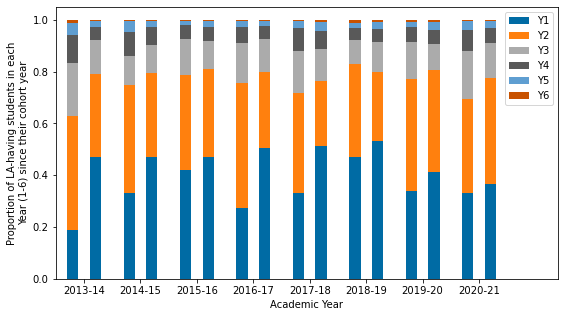

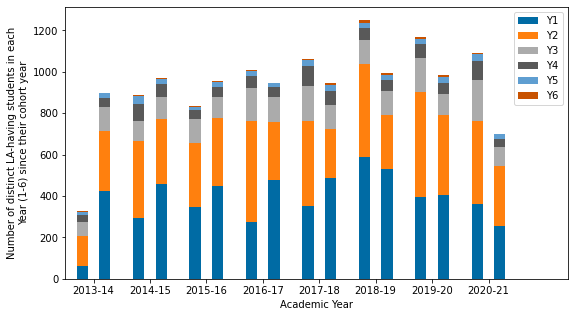

In [46]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
plt.bar(terms,prc_LAstudents[0,:], width=2, label="Y1")
plt.bar(terms,prc_LAstudents[1,:],bottom=np.sum(prc_LAstudents[:1,:],0), width=2, label="Y2")
plt.bar(terms,prc_LAstudents[2,:],bottom=np.sum(prc_LAstudents[:2,:],0), width=2, label="Y3")
plt.bar(terms,prc_LAstudents[3,:],bottom=np.sum(prc_LAstudents[:3,:],0), width=2, label="Y4")
plt.bar(terms,prc_LAstudents[4,:],bottom=np.sum(prc_LAstudents[:4,:],0), width=2, label="Y5")
plt.bar(terms,prc_LAstudents[5,:],bottom=np.sum(prc_LAstudents[:5,:],0), width=2, label="Y6")
plt.xlim([2128,2217]); plt.legend();
plt.xticks([2133,2143,2153,2163,2173,2183,2193,2203],
           labels=["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
plt.xlabel("Academic Year");
plt.ylabel("Proportion of LA-having students in each\nYear (1-6) since their cohort year");
plt.savefig('LAstudentBreakdownByYear_prc.png')

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
plt.bar(terms,num_LAstudents[0,:], width=2, label="Y1")
plt.bar(terms,num_LAstudents[1,:],bottom=np.sum(num_LAstudents[:1,:],0), width=2, label="Y2")
plt.bar(terms,num_LAstudents[2,:],bottom=np.sum(num_LAstudents[:2,:],0), width=2, label="Y3")
plt.bar(terms,num_LAstudents[3,:],bottom=np.sum(num_LAstudents[:3,:],0), width=2, label="Y4")
plt.bar(terms,num_LAstudents[4,:],bottom=np.sum(num_LAstudents[:4,:],0), width=2, label="Y5")
plt.bar(terms,num_LAstudents[5,:],bottom=np.sum(num_LAstudents[:5,:],0), width=2, label="Y6")
plt.xlim([2128,2217]); plt.legend();
plt.xticks([2133,2143,2153,2163,2173,2183,2193,2203],
           labels=["2013-14","2014-15","2015-16","2016-17","2017-18","2018-19","2019-20","2020-21"]);
plt.xlabel("Academic Year");
plt.ylabel("Number of distinct LA-having students in each\nYear (1-6) since their cohort year");
plt.savefig('LAstudentBreakdownByYear_num.png')


Compute the numbers matrices:

In [281]:
mats_LA = {c : None for c in cohort_terms_full+cohort_terms_part}
mats_noLA = {c : None for c in cohort_terms_full+cohort_terms_part}
for c in cohort_terms_full+cohort_terms_part:
    mats_LA[c] = compute_matrix_las(dfLAcoursestudents_LA,c)
    mats_noLA[c] = compute_matrix_las(dfLAcoursestudents_noLA,c)

Numbers matrices for COS majors

In [284]:
mats_LA_cos = {c : None for c in cohort_terms_full+cohort_terms_part}
mats_noLA_cos = {c : None for c in cohort_terms_full+cohort_terms_part}
for c in cohort_terms_full+cohort_terms_part:
    mats_LA_cos[c] = compute_matrix_las(dfLAcoursestudents_LA.loc[dfLAcoursestudents_LA.ID.isin(IDs_cos)],c)
    mats_noLA_cos[c] = compute_matrix_las(dfLAcoursestudents_noLA.loc[dfLAcoursestudents_noLA.ID.isin(IDs_cos)],c)

Normalize them individually, since might want to look at differences from estimating using a single cohort vs all:

(full-data cohorts only)

Will get a divide-by-zero error for the normalization of the PHYS no-LA matrices for one of the cohort years. Highlights the importance of the ability of this approach to combine information across cohorts!

In [285]:
pmats_LA = {c : normalize(mats_LA[c]) for c in cohort_terms_full}
pmats_noLA = {c : normalize(mats_noLA[c]) for c in cohort_terms_full}

pmats_LA_cos = {c : normalize(mats_LA_cos[c]) for c in cohort_terms_full}
pmats_noLA_cos = {c : normalize(mats_noLA_cos[c]) for c in cohort_terms_full}

But the focus is probably on the entire combined matrix, so combine them, and normalize:

In [286]:
mats_LA["all"] = np.sum([mats_LA[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_LA["all"] = normalize(mats_LA["all"])
mats_LA["full"] = np.sum([mats_LA[c] for c in cohort_terms_full], axis=0)
pmats_LA["full"] = normalize(mats_LA["full"])

mats_noLA["all"] = np.sum([mats_noLA[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_noLA["all"] = normalize(mats_noLA["all"])
mats_noLA["full"] = np.sum([mats_noLA[c] for c in cohort_terms_full], axis=0)
pmats_noLA["full"] = normalize(mats_noLA["full"])

# for COS majors
mats_LA_cos["all"] = np.sum([mats_LA_cos[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_LA_cos["all"] = normalize(mats_LA_cos["all"])
mats_LA_cos["full"] = np.sum([mats_LA_cos[c] for c in cohort_terms_full], axis=0)
pmats_LA_cos["full"] = normalize(mats_LA_cos["full"])

mats_noLA_cos["all"] = np.sum([mats_noLA_cos[c] for c in cohort_terms_full+cohort_terms_part], axis=0)
pmats_noLA_cos["all"] = normalize(mats_noLA_cos["all"])
mats_noLA_cos["full"] = np.sum([mats_noLA_cos[c] for c in cohort_terms_full], axis=0)
pmats_noLA_cos["full"] = normalize(mats_noLA_cos["full"])

### Compare Y1 retention:

Y1 retention is notably higher among students who have had LAs than those who did not. Full-data only vs using all cohorts (including partial data) don't have much of an effect.

The matrices at the top are for all (full+partial) cohorts

In [287]:
print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("LAs:")
printmat(mats_LA["all"])
print("\nNo LAs:")
printmat(mats_noLA["all"])

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("LAs:")
printmat(mats_LA_cos["all"])
print("\nNo LAs:")
printmat(mats_noLA_cos["all"])

All students who touched LA-assisted courses:

LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     3903       359           0
2     5206       405           9
3     4439       167          79
4     2660       101         990
5      441        75        1629
6                162         311

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1     8607      1190           1
2     6678       671          14
3     5291       254         149
4     2711       122        1459
5      529        59        1511
6                181         348


All students who touched LA-assisted courses, and ever had a COS major:

LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1      892       116           0
2      909        87           3
3      737        44          27
4      214        26         366
5       52         5         123
6                 20          35

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
-----------

In [288]:
print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("W/ LAs:")
printmat(pmats_LA["all"])
print("\nNo LAs:")
printmat(pmats_noLA["all"])
print()
print("Using Full-data cohorts only")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA["full"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA["full"][0,1]))
print("Using Full and Partial-data cohorts")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA["all"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA["all"][0,1]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("W/ LAs:")
printmat(pmats_LA_cos["all"])
print("\nNo LAs:")
printmat(pmats_noLA_cos["all"])
print()
print("Using Full-data cohorts only")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA_cos["full"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA_cos["full"][0,1]))
print("Using Full and Partial-data cohorts")
print("  Y1 retention among LA-having students {:0.3f}".format(pmats_LA_cos["all"][0,1]))
print("  Y1 retention among students w/ no LAs {:0.3f}".format(pmats_noLA_cos["all"][0,1]))

All students who touched LA-assisted courses:

W/ LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.916      0.084         0.0
2    0.926      0.072       0.002
3    0.947      0.036       0.017
4    0.709      0.027       0.264
5    0.206      0.035       0.759
6               0.342       0.658

No LAs:
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.878      0.121         0.0
2    0.907      0.091       0.002
3    0.929      0.045       0.026
4    0.632      0.028        0.34
5    0.252      0.028        0.72
6               0.342       0.658

Using Full-data cohorts only
  Y1 retention among LA-having students 0.927
  Y1 retention among students w/ no LAs 0.869
Using Full and Partial-data cohorts
  Y1 retention among LA-having students 0.916
  Y1 retention among students w/ no LAs 0.878


All students who touched LA-assisted courses, and ever had a COS major:

W/ LAs:
N   YN->N+1  YN->DropOut  YN->Grad
--------------------

### Compare 4Y graduation rate:

In [289]:
n = 4

print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["full"],n), np.linalg.matrix_power(pmats_noLA["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["all"],n), np.linalg.matrix_power(pmats_noLA["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["full"],n), np.linalg.matrix_power(pmats_noLA_cos["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["all"],n), np.linalg.matrix_power(pmats_noLA_cos["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))


All students who touched LA-assisted courses:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.603 0.    0.171 0.226]
No LAs:
 [0.    0.    0.    0.    0.467 0.    0.269 0.264]
4Y graduate rate among LA-having students 0.226
4Y graduate rate among students w/ no LAs 0.264

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.57  0.    0.202 0.228]
No LAs:
 [0.    0.    0.    0.    0.468 0.    0.258 0.274]
4Y graduate rate among LA-having students 0.228
4Y graduate rate among students w/ no LAs 0.274


All students who touched LA-assisted courses, and ever had a COS major:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.286 0.    0.25  0.464]
No LAs:
 [0.    0.    0.    0.    0.317 0.    0.36  0.323]
4Y graduate rate among LA-having students 0.464
4Y graduate rate among students w/ no LAs 0.323

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.259 0.    0.268 0.473]
No LAs:
 [0.    0.    0.    0.    0.31  0.    0.341 0

### Compare 6Y graduation rate:

In [290]:
n = 6

print("=======================================================")
print("All students who touched LA-assisted courses:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["full"],n), np.linalg.matrix_power(pmats_noLA["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA["all"],n), np.linalg.matrix_power(pmats_noLA["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n\n=======================================================")
print("All students who touched LA-assisted courses, and ever had a COS major:\n")
print("Using only Full-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["full"],n), np.linalg.matrix_power(pmats_noLA_cos["full"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\nUsing Full and Partial-data Cohorts:")
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmats_LA_cos["all"],n), np.linalg.matrix_power(pmats_noLA_cos["all"],n)
print("LAs:\n",np.round(newmats_LA,3)[0,:])
print("No LAs:\n",np.round(newmats_noLA,3)[0,:])
print("{}Y graduate rate among LA-having students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))


All students who touched LA-assisted courses:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.234 0.766]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.323 0.677]
6Y graduate rate among LA-having students 0.766
6Y graduate rate among students w/ no LAs 0.677

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.262 0.738]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.312 0.688]
6Y graduate rate among LA-having students 0.738
6Y graduate rate among students w/ no LAs 0.688


All students who touched LA-assisted courses, and ever had a COS major:

Using only Full-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.288 0.712]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.402 0.598]
6Y graduate rate among LA-having students 0.712
6Y graduate rate among students w/ no LAs 0.598

Using Full and Partial-data Cohorts:
LAs:
 [0.    0.    0.    0.    0.    0.    0.302 0.698]
No LAs:
 [0.    0.    0.    0.    0.    0.    0.382 0

<br>

---

<h1 style="font-size:24pt;color:purple">Restricting to specific high-DFW COS courses</h1>

In [55]:
cohort_terms = cohort_terms_full+cohort_terms_part

def matrices_for_course_list(courses, LAclass_tups, df, cohort_terms):
    # input: courses (list of (SUBJ, CRS#) tuples), LAclass_tups, df, list of terms to use

    IDs_these_courses, IDs_LAs_these_courses = set(), set()
    LA_tups_these_courses = []
    for c in courses:
        IDs_these_courses = set.union(IDs_these_courses,
                                      df.loc[(df.subject==c[0]) & (df.catalog_nbr==c[1]),"ID"].unique())
        this_class = [LAclass_tups[k][0]==c[0] and LAclass_tups[k][1]==c[1] for k in range(len(LAclass_tups))]
        if np.sum(this_class) > 0:
            LA_tups_this_class = [LAclass_tups[k] for k in [i for i, x in enumerate(this_class) if x]]
            LA_tups_these_courses = LA_tups_these_courses + list(LA_tups_this_class)
            for cs in LA_tups_this_class:
                IDs_LAs_these_courses = set.union(IDs_LAs_these_courses,
                                                  df.loc[(df.subject==cs[0]) & (df.catalog_nbr==cs[1]) & 
                                                         (df.class_section==cs[2]) & (df.Term==cs[3]),"ID"].unique())
    # restrict to only the list of courses
    dfC_all = df.loc[(df.ID.isin(IDs_these_courses))]
    dfC_LA = df.loc[(df.ID.isin(IDs_LAs_these_courses))]
    dfC_noLA = df.loc[(~df.ID.isin(IDs_LAs_these_courses))]

    # numbers matrices for these courses
    mats_LA_these_courses = {c : None for c in cohort_terms}
    mats_noLA_these_courses = {c : None for c in cohort_terms}
    for c in cohort_terms:
        mats_LA_these_courses[c] = compute_matrix_las(dfC_LA,c,True,False)
        mats_noLA_these_courses[c] = compute_matrix_las(dfC_noLA,c,True,False)

    # sum across cohort terms and normalize    
    mats_LA_these_courses["all"] = np.sum([mats_LA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_LA_these_courses = normalize(mats_LA_these_courses["all"])
    mats_noLA_these_courses["all"] = np.sum([mats_noLA_these_courses[c] for c in cohort_terms], axis=0)
    pmats_noLA_these_courses = normalize(mats_noLA_these_courses["all"])

    return (pmats_LA_these_courses, pmats_noLA_these_courses, mats_LA_these_courses, mats_noLA_these_courses)

<br>

### High-DFW COS courses

Including:
* PHYS: 111, 112, 211A, 211, 212
* MATH: 111, 171, 182A, 211
  * Note that there are no instances of MATH 172, 181(A), or 182 using LAs.
  * There is a single instance of MATH 182A using an LA.
  * Results without MATH 211 is below this. However, there's an overall DFW rate of 25% in that course, between Fall 2013 and Fall 2019 (see further below)
  
Y1 retention:
* Among students who have LAs in this set of courses: 97%
* Non-LA students in this same set of courses: 87%

In [56]:
courses = [("PHYS","111"),("PHYS","112"),("PHYS","211"),("PHYS","211A"),("PHYS","212"),
           ("MATH","111"), ("MATH","171"),("MATH","182A"),("MATH","211")]
pmat_LA_dfw, pmat_noLA_dfw, mats_LA_dfw, mats_noLA_dfw = matrices_for_course_list(courses,
                                                                                  LAclass_tups, df, cohort_terms)
# Y1 retention
printmat(pmat_LA_dfw)
printmat(pmat_noLA_dfw)
# 4-year grad rate
n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))
# 6-year grad rate
n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students {:0.3f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs {:0.3f}".format(n,newmats_noLA[0,7]))

print("\n", int(mats_LA_dfw["all"][0,1]), "students starting in Y1 with LA in a high-DFW COS course")

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.946      0.054         0.0
2    0.937      0.063         0.0
3    0.965      0.031       0.004
4    0.813      0.021       0.166
5    0.219      0.037       0.744
6               0.329       0.671
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.866      0.134         0.0
2    0.912      0.087       0.001
3    0.938      0.043       0.019
4    0.544      0.029       0.427
5    0.251      0.027       0.722
6               0.403       0.597
LAs:
 [0.     0.     0.     0.     0.6951 0.     0.1594 0.1455]
No LAs:
 [0.     0.     0.     0.     0.4035 0.     0.2643 0.3322]
4Y graduate rate among LA-having high-DFW COS course students 0.145
4Y graduate rate among high-DFW COS course students w/ no LAs 0.332
LAs:
 [0.     0.     0.     0.     0.     0.     0.2354 0.7646]
No LAs:
 [0.     0.     0.     0.     0.     0.     0.3161 0.6839]
6Y graduate rate among LA-having high-DFW COS course s

<br>

### Confidence intervals for difference in proportions

$$\hat{p}_1 - \hat{p}_2 \pm z_{\alpha/2} \sqrt{\dfrac{\hat{p}_1(1-\hat{p}_1)}{n_1} + \dfrac{\hat{p}_2(1-\hat{p}_2)}{n_2}}$$

For a transition probability in row $i$, the sample sizes $n_1$ and $n_2$ should be the total number of students from row $i$.

In [57]:
z_10 = stats.norm.ppf(1-0.1/2)
z_05 = stats.norm.ppf(1-0.05/2)
z_01 = stats.norm.ppf(1-0.01/2)

#### For year-to-year transitions

In [58]:
significances = np.zeros(pmat_LA_dfw.shape)
for i in range(pmat_LA_dfw.shape[0]):
    for j in range(pmat_LA_dfw.shape[1]):
        p1, p2 = pmat_LA_dfw[i,j], pmat_noLA_dfw[i,j]
        n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
        pdiff = p1-p2
        pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
        ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
        if np.prod(ci_99) > 0:
            significances[i,j] = 0.01
        else:
            ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
            if np.prod(ci_95) > 0:
                significances[i,j] = 0.05
            else:
                ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
                if np.prod(ci_90) > 0:
                    significances[i,j] = 0.1

In [59]:
significances    

array([[0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.05, 0.01],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.1 , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.05],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

<br>

#### Significance for the 4Y and 6Y graduation rates

These are the proportions moving from Y1 to Grad states in 4 or 6 steps. So the denominators for these proportions are the Y1 totals.

In [60]:
i,j = 0,7

n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("4Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("4Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("4Y grad rate difference significant at 10%")
        else:
            print("4Y grad rate difference NOT significant")

n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw,n), np.linalg.matrix_power(pmat_noLA_dfw,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw["all"][i,:]), np.sum(mats_noLA_dfw["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("6Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("6Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("6Y grad rate difference significant at 10%")
        else:
            print("6Y grad rate difference NOT significant")

4Y grad rate difference significant at 1%
6Y grad rate difference significant at 1%


<br>

#### Calculate numbers of students in each of the courses, and numbers of sections

In [61]:
student_counts_LA, section_counts_LA = np.zeros((len(courses),len(terms))), np.zeros((len(courses),len(terms)))
student_counts_noLA, section_counts_noLA = np.zeros((len(courses),len(terms))), np.zeros((len(courses),len(terms)))
total_no_student = 0
for t in terms:
    ti = list(terms).index(t)
    for c in courses:
        ci = courses.index(c)
        subj = c[0]
        crs = c[1]
        dfSubset = df.loc[(df.subject==subj) & (df.catalog_nbr==crs) & (df.Term==t)].copy()
        # LA sections of this course this term, excluding recitation, lab, and "splits"
        LA_tups_this_class = [tup for tup in LAclass_tups if (tup[0]==subj and tup[1]==crs and tup[3]==t and
                                                              "L" not in tup[2] and "R" not in tup[2] and "S" not in tup[2])]
        # check that they actually have students in them
        num_no_students = 0
        LA_sections = []
        for tup in LA_tups_this_class:
            num_students_this_section = len(dfSubset.loc[(dfSubset.class_section==tup[2]),"ID"].unique())
            student_counts_LA[ci,ti] += num_students_this_section
            LA_sections.append(tup[2])
            if num_students_this_section==0:
                num_no_students += 1
                total_no_student += 1
        section_counts_LA[ci,ti] = len(LA_tups_this_class) - num_no_students
        # non-LA sections of this course, this term, ... 
        sections_this_term = dfSubset.loc[(dfSubset["class_section"].str.find("S")==-1) &
                                          (dfSubset["class_section"].str.find("R")==-1) & 
                                          (dfSubset["class_section"].str.find("L")==-1),"class_section"].unique()
        noLA_sections = list(set.difference(set(sections_this_term), set(LA_sections)))
        section_counts_noLA[ci,ti] = len(noLA_sections) 
        # non-LA students this course
        for sec in noLA_sections:
            student_counts_noLA[ci,ti] += len(dfSubset.loc[(dfSubset["class_section"]==sec),"ID"].unique())
        

In [62]:
csv_to_write = []
for c in courses:
    ci = courses.index(c)
    row_str_LA = c[0]+c[1]+" LA"
    row_str_noLA = c[0]+c[1]+" no-LA"
    for t in terms:
        ti = list(terms).index(t)
        row_str_LA = row_str_LA + "," + str(int(student_counts_LA[ci,ti])) + " (" + str(int(section_counts_LA[ci,ti])) + ")"
        row_str_noLA = row_str_noLA + "," + str(int(student_counts_noLA[ci,ti])) + " (" + str(int(section_counts_noLA[ci,ti])) + ")"
    row_str_LA = row_str_LA + "," + str(int(np.sum(student_counts_LA[ci,:]))) + " (" + str(int(np.sum(section_counts_LA[ci,:]))) + ")"
    row_str_noLA = row_str_noLA + "," + str(int(np.sum(student_counts_noLA[ci,:]))) + " (" + str(int(np.sum(section_counts_noLA[ci,:]))) + ")"
    csv_to_write.append(row_str_LA)
    csv_to_write.append(row_str_noLA)


In [63]:
pd.DataFrame(csv_to_write).to_csv("counts.csv")

In [64]:
np.sum(student_counts_LA), np.sum(student_counts_noLA)

(6130.0, 26970.0)

<br>

### Same, subsetting down to only students who ever had a COS major

In [65]:
pmat_LA_dfw_cos, pmat_noLA_dfw_cos, mats_LA_dfw_cos, mats_noLA_dfw_cos = matrices_for_course_list(courses, 
                                                                                                  LAclass_tups, 
                                                                                                  df.loc[df.ID.isin(IDs_cos)], 
                                                                                                  cohort_terms)
# Y1 retention
printmat(pmat_LA_dfw_cos)
printmat(pmat_noLA_dfw_cos)
# 4-year grad rate
n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students (COS-only) {:0.4f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) {:0.4f}".format(n,newmats_noLA[0,7]))
# 6-year grad rate
n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
print("LAs:\n",np.round(newmats_LA,4)[0,:])
print("No LAs:\n",np.round(newmats_noLA,4)[0,:])
print("{}Y graduate rate among LA-having high-DFW COS course students (COS-only) {:0.4f}".format(n,newmats_LA[0,7]))
print("{}Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) {:0.4f}".format(n,newmats_noLA[0,7]))

print("\n", int(mats_LA_dfw_cos["all"][0,1]), "students starting in Y1 with LA in a high-DFW COS course (COS-only)")

N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.951      0.049         0.0
2    0.926      0.074         0.0
3    0.943      0.039       0.017
4    0.433      0.022       0.545
5    0.241      0.034       0.724
6               0.571       0.429
N   YN->N+1  YN->DropOut  YN->Grad
----------------------------------
1    0.866      0.134         0.0
2    0.909      0.089       0.002
3     0.91       0.06        0.03
4    0.369      0.048       0.583
5    0.302      0.017       0.682
6               0.407       0.593
LAs:
 [0.     0.     0.     0.     0.3596 0.     0.172  0.4684]
No LAs:
 [0.     0.     0.     0.     0.2643 0.     0.2923 0.4433]
4Y graduate rate among LA-having high-DFW COS course students (COS-only) 0.4684
4Y graduate rate among high-DFW COS course students w/ no LAs (COS-only) 0.4433
LAs:
 [0.    0.    0.    0.    0.    0.    0.234 0.766]
No LAs:
 [0.     0.     0.     0.     0.     0.     0.3293 0.6707]
6Y graduate rate among LA-having high-

Significances for year-to-year transitions:

In [66]:
significances_cos = np.zeros(pmat_LA_dfw_cos.shape)
for i in range(pmat_LA_dfw_cos.shape[0]):
    for j in range(pmat_LA_dfw_cos.shape[1]):
        p1, p2 = pmat_LA_dfw_cos[i,j], pmat_noLA_dfw_cos[i,j]
        n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
        pdiff = p1-p2
        pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
        ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
        if np.prod(ci_99) > 0:
            significances_cos[i,j] = 0.01
        else:
            ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
            if np.prod(ci_95) > 0:
                significances_cos[i,j] = 0.05
            else:
                ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
                if np.prod(ci_90) > 0:
                    significances_cos[i,j] = 0.1
print(significances_cos)

[[0.   0.01 0.   0.   0.   0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.1  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.1  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


Significances for 4y and 6y graduation rates:

In [67]:
i,j = 0,7

n=4
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("4Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("4Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("4Y grad rate difference significant at 10%")
        else:
            print("4Y grad rate difference NOT significant")

n=6
newmats_LA, newmats_noLA = np.linalg.matrix_power(pmat_LA_dfw_cos,n), np.linalg.matrix_power(pmat_noLA_dfw_cos,n)
p1, p2 = newmats_LA[i,j], newmats_noLA[i,j]
n1, n2 = np.sum(mats_LA_dfw_cos["all"][i,:]), np.sum(mats_noLA_dfw_cos["all"][i,:])
pdiff = p1-p2
pdiff_std = np.sqrt( p1*(1-p1)/n1 + p2*(1-p2)/n2 )
ci_99 = [pdiff + pm*z_01*pdiff_std for pm in [-1,1]]
if np.prod(ci_99) > 0:
    print("6Y grad rate difference significant at 1%")
else:
    ci_95 = [pdiff + pm*z_05*pdiff_std for pm in [-1,1]]
    if np.prod(ci_95) > 0:
        print("6Y grad rate difference significant at 5%")
    else:
        ci_90 = [pdiff + pm*z_10*pdiff_std for pm in [-1,1]]
        if np.prod(ci_90) > 0:
            print("6Y grad rate difference significant at 10%")
        else:
            print("6Y grad rate difference NOT significant")

4Y grad rate difference NOT significant
6Y grad rate difference significant at 1%


<br>

---

# STASHED CODE


---

<br>

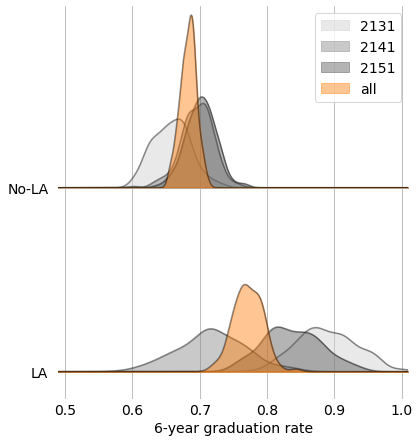

In [58]:
tmp = {"No-LA" : sygr_noLA, "LA" : sygr_LA}

fig, ax = joypy.joyplot(tmp, color=["C9","C6","C3","C1"], alpha=0.45, overlap=.5, legend=True, 
                        grid=True, figsize=(6,6), xlabelsize=14, ylabelsize=14, x_range=[0.49,1.01])
ax[2].set_xlabel("6-year graduation rate", fontsize=14);
ax[0].legend(fontsize=14);

Here, actually want to group by year instead of LA/no-LA

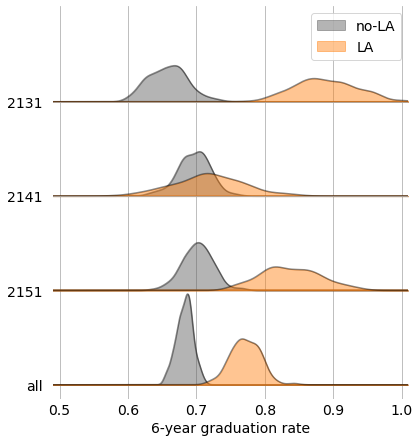

In [67]:
tmp = {k : {"no-LA" : sygr_noLA[k], "LA" : sygr_LA[k]} for k in sygr_LA.keys()}

fig, ax = joypy.joyplot(tmp, color=["C3","C1"], alpha=0.45, overlap=.31, legend=True, 
                        grid=True, figsize=(6,6), xlabelsize=14, ylabelsize=14, x_range=[0.49,1.01])
ax[4].set_xlabel("6-year graduation rate", fontsize=14);
ax[0].legend(fontsize=14);